# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import fbprophet as prophet
import matplotlib as matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
import matplotlib as mpl
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import stattools
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import re

ModuleNotFoundError: No module named 'statsmodels'

In [248]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

In [249]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [250]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [251]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [252]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [253]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [254]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [255]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dataset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [256]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [257]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [258]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [259]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

#Guardamos el dataset (ejecutado una sola vez)
dataset.to_csv("dataset_00.csv")
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

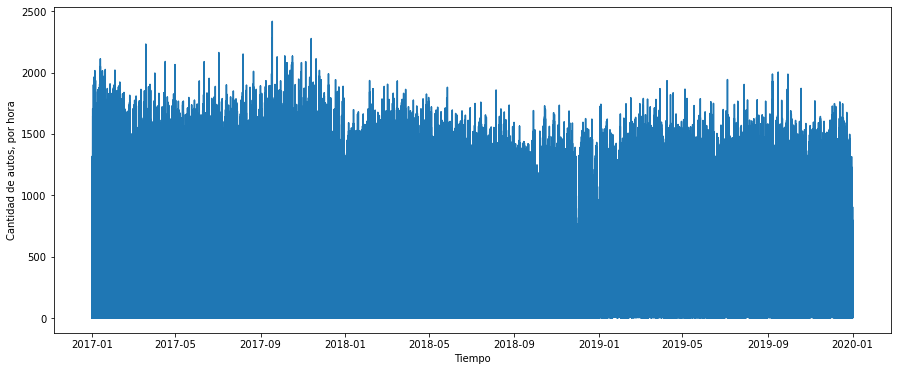

In [260]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [261]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

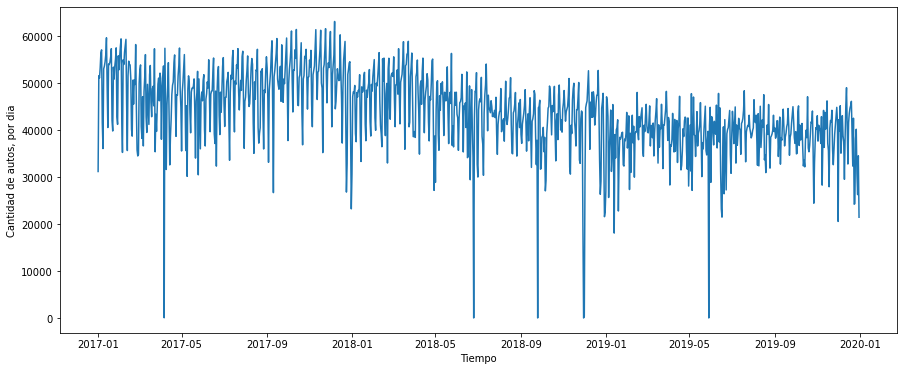

In [262]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## Análisis Exploratorio de Datos (EDA)

In [263]:
data00=pd.read_csv("dataset_00.csv",index_col=0)
data00.isna().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

Verificamos que el Dataset que vamos a utilizar no tiene datos faltantes.

### Exploración del Dataset

In [264]:
data00

dia    sentido tipo_vehiculo  cantidad_pasos                fecha
0       Domingo  Provincia        Pesado               1  2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9  2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644  2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6  2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1  2017-01-01 00:00:00
...         ...        ...           ...             ...                  ...
238864   Martes  Provincia       Liviano             556  2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1  2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580  2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214  2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190  2019-12-31 23:00:00

[238869 rows x 5 columns]

En un primer vistazo tenemos un Dataset de 238869 filas con la siguiente información:
- Día de la semana 
- Sentido de circulación
- Tipo de vehículo
- Cantidad de pasos: Cantidad de vehículos que pasaron por el peaje de Illia y que pagaron en efectivo.
- Fecha: Día y horario

In [265]:
for i in data00.columns:
    print(i,":",dataset[i].unique())

dia : ['Domingo' 'Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado']
sentido : ['Provincia' 'Centro']
tipo_vehiculo : ['Pesado' 'Liviano']
cantidad_pasos : [   1    9  644 ... 2004 1938 1987]
fecha : ['2017-01-01T00:00:00.000000000' '2017-01-01T01:00:00.000000000'
 '2017-01-01T02:00:00.000000000' ... '2019-12-31T21:00:00.000000000'
 '2019-12-31T22:00:00.000000000' '2019-12-31T23:00:00.000000000']


A simple vista podemos notar que los valores para cada variable son coherentes.

In [266]:
data00.head(20)

dia    sentido tipo_vehiculo  cantidad_pasos                fecha
0   Domingo  Provincia        Pesado               1  2017-01-01 00:00:00
1   Domingo  Provincia       Liviano               9  2017-01-01 00:00:00
2   Domingo  Provincia       Liviano             644  2017-01-01 00:00:00
3   Domingo  Provincia        Pesado               6  2017-01-01 00:00:00
4   Domingo  Provincia        Pesado               1  2017-01-01 00:00:00
5   Domingo  Provincia        Pesado               2  2017-01-01 00:00:00
6   Domingo     Centro       Liviano              23  2017-01-01 00:00:00
7   Domingo     Centro        Pesado               1  2017-01-01 00:00:00
8   Domingo     Centro        Pesado              21  2017-01-01 00:00:00
9   Domingo     Centro        Pesado              10  2017-01-01 00:00:00
10  Domingo     Centro        Pesado               1  2017-01-01 00:00:00
11  Domingo     Centro       Liviano             857  2017-01-01 00:00:00
12  Domingo     Centro       Liviano               1  2017-01-01 01:00:00
13  Domingo  Provincia       Liviano             561  2017-01-01 02:00:00
14  Domingo  Provincia        Pesado               5  2017-01-01 02:00:00
15  Domingo     Centro       Liviano              10  2017-01-01 02:00:00
16  Domingo     Centro       Liviano             783  2017-01-01 02:00:00
17  Domingo     Centro        Pesado               3  2017-01-01 02:00:00
18  Domingo  Provincia       Liviano              12  2017-01-01 02:00:00
19  Domingo  Provincia       Liviano             704  2017-01-01 03:00:00

Como podemos ver en la tabla anterior, la información no es muy fácil de interpretar ya que para un día y hora determinada existen varias entradas. 

Para un día y hora determinados deberíamos tener como máximo 4 entradas (Provincia-Liviano; Provincia-Pesado; Centro-Liviano; Centro-Pesado), sin embargo tenemos más de cuatro en algunos casos lo que puede deberse a las columnas que eliminamos anteriormente. 

Posteriormente quizás debamos tener que dividir nuestro dataset en estos cuatro casos y considerar para cada uno de estos 4 casos un dataset con la cantidad de pasos por hora y otro con la cantidad de pasos por día, dando un total de 8 datasets.

Para tener una noción general de la distribución de la cantidad de pasos diaria utilizaremos el dataset anteriormente resampleado a frecuencia diaria.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C811AD6AF0>]],
      dtype=object)

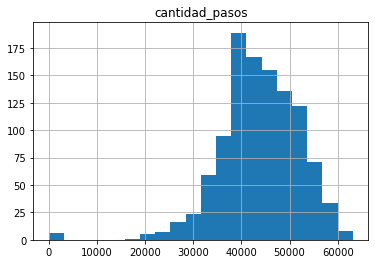

In [267]:
diario.hist(bins=20)

In [268]:
#Hacemos una copia de nuestro dataset inicial (data00) y agregamos una columna que llamaremos fecha_dia 
#con la información sólo del día y lo guardamos como "dataset_01.csv"
data01=data00.copy()
data01["fecha"]=pd.to_datetime(data01.fecha)
data01['fecha_dia'] = data01['fecha'].dt.date
data01.to_csv('dataset_01.csv', index=False)
data01

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00   
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00   
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00   
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00   
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00   

         fecha_dia  
0       2017-01-01  
1       2017-01-01  
2       2017-01-01  
3       2017-01-01  
4       2017-01-01  
...            ...  
238864  2019-12-31  
238865  2019-12-31  
238866  2019-12-31  
238867  2019-12-31  
238868  2019-12-31  

[238869 rows x 6 columns]

Vamos a tratar de entender un poco más el dataset dividiéndolo en partes y agrupándolo por días para poder estudiarlo mejor.

In [269]:
data01=pd.read_csv("dataset_01.csv")

mask_provincia=data01["sentido"]=='Provincia'
mask_centro=data01["sentido"]=='Centro'
mask_liviano=data01["tipo_vehiculo"]=='Liviano'
mask_pesado=data01["tipo_vehiculo"]=='Pesado'

mask_provincia_pesado = np.logical_and(data01.sentido=='Provincia', data01.tipo_vehiculo == 'Pesado')
mask_provincia_liviano = np.logical_and(data01.sentido=='Provincia', data01.tipo_vehiculo == 'Liviano')
mask_centro_pesado = np.logical_and(data01.sentido=='Centro', data01.tipo_vehiculo == 'Pesado')
mask_centro_liviano = np.logical_and(data01.sentido=='Centro', data01.tipo_vehiculo == 'Liviano')

In [270]:
data_provincia_diario = data01[mask_provincia].groupby(by="fecha_dia").sum()
data_provincia_horario = data01[mask_provincia].groupby(by="fecha").sum()

data_centro_diario = data01[mask_centro].groupby(by="fecha_dia").sum()
data_centro_horario = data01[mask_centro].groupby(by="fecha").sum()

data_liviano_diario = data01[mask_liviano].groupby(by="fecha_dia").sum()
data_liviano_horario = data01[mask_liviano].groupby(by="fecha").sum()

data_pesado_diario = data01[mask_pesado].groupby(by="fecha_dia").sum()
data_pesado_horario = data01[mask_pesado].groupby(by="fecha").sum()

In [271]:
data_provincia_pesado_horario = data01[mask_provincia_pesado].groupby(by="fecha").sum()
data_provincia_pesado_diario = data01[mask_provincia_pesado].groupby(by="fecha_dia").sum()

In [272]:
data_provincia_liviano_horario = data01[mask_provincia_liviano].groupby(by="fecha").sum()
data_provincia_liviano_diario = data01[mask_provincia_liviano].groupby(by="fecha_dia").sum()

In [273]:
data_centro_pesado_horario = data01[mask_centro_pesado].groupby(by="fecha").sum()
data_centro_pesado_diario = data01[mask_centro_pesado].groupby(by="fecha_dia").sum()

In [274]:
data_centro_liviano_horario = data01[mask_centro_liviano].groupby(by="fecha").sum()
data_centro_liviano_diario = data01[mask_centro_liviano].groupby(by="fecha_dia").sum()

## Análisis diario

#### Comparación sentido de circulación

In [275]:
data_provincia_diario.index = pd.to_datetime(data_provincia_diario.index)
data_centro_diario.index = pd.to_datetime(data_centro_diario.index)

In [276]:
data_provincia_diario

cantidad_pasos
fecha_dia                 
2017-01-01           14132
2017-01-02           23743
2017-01-03           23526
2017-01-04           24383
2017-01-05           25666
...                    ...
2019-12-27           18995
2019-12-28           14686
2019-12-29           12544
2019-12-30           15924
2019-12-31           10472

[1091 rows x 1 columns]

In [277]:
data_provincia_diario.describe()

cantidad_pasos
count     1091.000000
mean     21226.594867
std       3727.084329
min          9.000000
25%      18875.000000
50%      21359.000000
75%      23917.500000
max      30458.000000

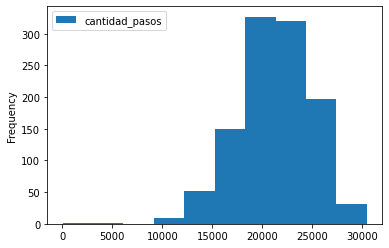

In [278]:
data_provincia_diario.plot(kind="hist")

In [279]:
data_centro_diario

cantidad_pasos
fecha_dia                 
2017-01-01           17051
2017-01-02           27825
2017-01-03           27567
2017-01-04           28949
2017-01-05           30820
...                    ...
2019-12-27           21187
2019-12-28           15995
2019-12-29           13715
2019-12-30           18599
2019-12-31           10975

[1091 rows x 1 columns]

In [280]:
data_centro_diario.describe()

cantidad_pasos
count     1091.000000
mean     22646.531622
std       4207.653075
min         31.000000
25%      20080.000000
50%      22316.000000
75%      25715.000000
max      32669.000000

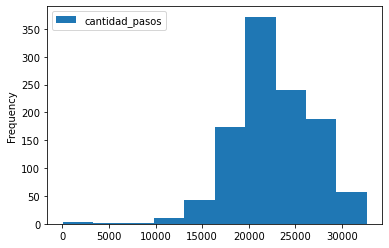

In [281]:
data_centro_diario.plot(kind="hist")

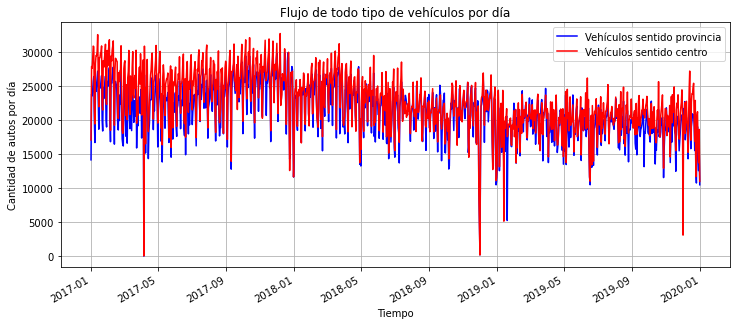

In [282]:
#fig,ax = plt.subplots(figsize = (15,6))
#data_provincia_diario.plot(ax=ax, x_compat=True,label = "Vehículos sentido provincia",legend=True)
#data_centro_diario.plot(ax=ax, x_compat=True,label = "Vehículos sentido centro",legend=True)
#ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
#plt.title("Flujo de todo tipo de vehículos por día")
#plt.xlabel('Tiempo')
#plt.ylabel('Cantidad de autos por día')
#plt.show()

plt.figure(figsize=(12,5))

ax1 = data_provincia_diario.cantidad_pasos.plot(color='blue', grid=True, label='Vehículos sentido provincia')
ax2 = data_centro_diario.cantidad_pasos.plot(color='red', grid=True, label='Vehículos sentido centro')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.title("Flujo de todo tipo de vehículos por día")
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por día')
plt.legend(l1+l2, loc=1)
plt.show()

- Como se puede ver en las tablas y gráficos anteriores no hay diferencias significativas entre la cantidad de vehículos que circulan hacia capital o hacia provincia, podemos decir que ambos datos se comportan de maneras similares.

- Esto podría estar justificado pensando que todo aquel que se trasladó de provincia hacia el centro, luego debe volver desde el centro a provincia y probablemente lo haga pasando por el mismo peaje.

- Sí puede notarse en el gráfico, que a comienzos de 2017 sí habían más vehículos que circulaban hacia el centro de la ciudad (línea roja) que aquellos que lo hacían hacia la provincia (línea azul).

- También de manera general podría destacarse un decrecimiento de la cantidad de vehículos que circulan a medida que pasan los años, sin embargo esta afirmación se caería al recordar que sólo estamos considerando vehículos que pagaron en efectivo. Es decir, que posiblemente la cantidad de vehículos no disminuyó pero ahora las personas eligen pagar con otro medio de pago.

#### Comparación tipo de vehículo

In [283]:
data_liviano_diario.index = pd.to_datetime(data_liviano_diario.index)
data_pesado_diario.index = pd.to_datetime(data_pesado_diario.index)

In [284]:
data_liviano_diario.describe()

cantidad_pasos
count     1091.000000
mean     42473.445463
std       7230.487327
min         40.000000
25%      38086.500000
50%      42401.000000
75%      47643.500000
max      60748.000000

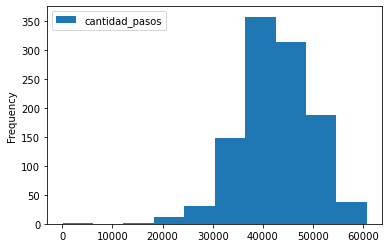

In [285]:
data_liviano_diario.plot(kind="hist")

In [286]:
data_pesado_diario.describe()

cantidad_pasos
count     1090.000000
mean      1400.965138
std        630.556446
min          7.000000
25%        878.250000
50%       1364.000000
75%       1911.000000
max       2983.000000

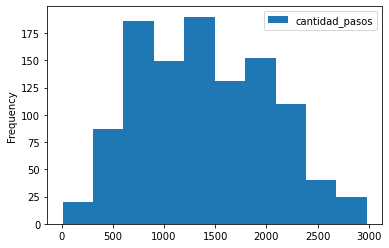

In [287]:
data_pesado_diario.plot(kind="hist")

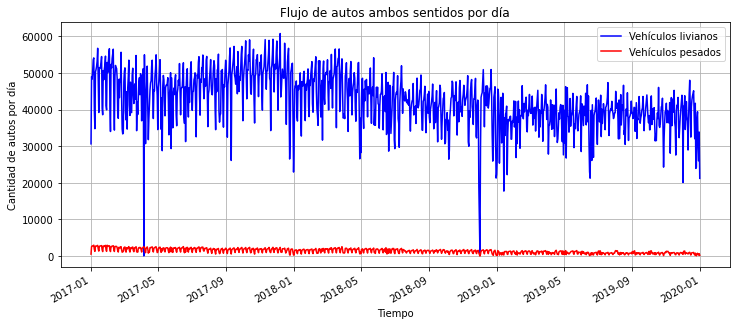

In [288]:
#fig,ax = plt.subplots(figsize = (15,6))
#data_liviano_diario.plot(ax=ax, x_compat=True,label = "Vehículos livianos",legend=True)
#data_pesado_diario.plot(ax=ax, x_compat=True,label = "Vehículos pesados",legend=True)
#ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
#plt.title("Flujo de autos ambos sentidos por día")
#plt.xlabel('Tiempo')
#plt.ylabel('Cantidad de autos por día')
#plt.show()

plt.figure(figsize=(12,5))

ax1 = data_liviano_diario.cantidad_pasos.plot(color='blue', grid=True, label='Vehículos livianos')
ax2 = data_pesado_diario.cantidad_pasos.plot(color='red', grid=True, label='Vehículos pesados')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.title("Flujo de autos ambos sentidos por día")
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por día')
plt.legend(l1+l2, loc=1)
plt.show()

De las tablas y gráficas anteriores podemos notar que el tipo de vehículo que más circula por este peaje (en cualquier sentido) es el vehículo liviano. 

El histograma de este tipo de vehículo (liviano) parece estar sesgado a la izquierda aunque si miramos la media y la mediana se encuentran muy cerca una de otra, por lo que podríamos considerar que el "sesgo" aparente puede deberse a la existencia de algún outlier o ruido blanco. Estos también pueden notarse en la gráfica en aquellos picos mínimos que presenta la línea azul (vehículo liviano).

Igual que con el análisis anterior, la serie tiene una leve tendencia negativa que como dijimos anteriormente no necesariamente indicaría una disminución de la circulación vehicular, sino precisamente una disminución de la cantidad de vehículos que abonan en efectivo.



### Pregunta a responder: ¿Cuáles son los días y horarios más transitados?

Primero para poder comenzar a realizar algún análisis que nos ayude a encontrar la respuesta a esta pregunta debemos preparar los datasets. Esto significa separar un dataset por cada día de la semana y un dataset por cada hora del día.

#### Día con más tráfico

In [289]:
data01=pd.read_csv("dataset_01.csv")

mask_domingo=data01["dia"]=='Domingo'
mask_lunes=data01["dia"]=='Lunes'
mask_martes=data01["dia"]=='Martes'
mask_miercoles=data01["dia"]=='Miércoles'
mask_jueves=data01["dia"]=='Jueves'
mask_viernes=data01["dia"]=='Viernes'
mask_sabado=data01["dia"]=='Sábado'

data_domingo_diario = data01[mask_domingo].groupby(by="fecha_dia").sum()
data_domingo_diario.index=pd.to_datetime(data_domingo_diario.index)
data_domingo_mensual=data_domingo_diario.resample("M").mean()


data_lunes_diario = data01[mask_lunes].groupby(by="fecha_dia").sum()
data_lunes_diario.index=pd.to_datetime(data_lunes_diario.index)
data_lunes_mensual=data_lunes_diario.resample("M").mean()

data_martes_diario = data01[mask_martes].groupby(by="fecha_dia").sum()
data_martes_diario.index=pd.to_datetime(data_martes_diario.index)
data_martes_mensual=data_martes_diario.resample("M").mean()

data_miercoles_diario = data01[mask_miercoles].groupby(by="fecha_dia").sum()
data_miercoles_diario.index=pd.to_datetime(data_miercoles_diario.index)
data_miercoles_mensual=data_miercoles_diario.resample("M").mean()

data_jueves_diario = data01[mask_jueves].groupby(by="fecha_dia").sum()
data_jueves_diario.index=pd.to_datetime(data_jueves_diario.index)
data_jueves_mensual=data_jueves_diario.resample("M").mean()

data_viernes_diario = data01[mask_viernes].groupby(by="fecha_dia").sum()
data_viernes_diario.index=pd.to_datetime(data_viernes_diario.index)
data_viernes_mensual=data_viernes_diario.resample("M").mean()

data_sabado_diario = data01[mask_sabado].groupby(by="fecha_dia").sum()
data_sabado_diario.index=pd.to_datetime(data_sabado_diario.index)
data_sabado_mensual=data_sabado_diario.resample("M").mean()

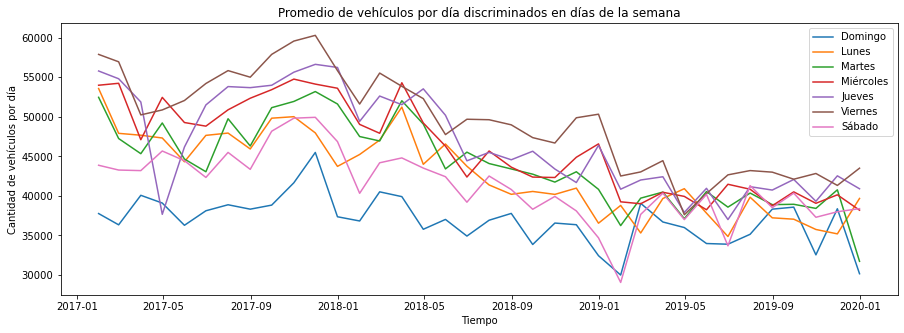

In [290]:
plt.figure(figsize = (15,5))
plt.plot(data_domingo_mensual.index, data_domingo_mensual.cantidad_pasos, label = 'Domingo')
plt.plot(data_lunes_mensual.index, data_lunes_mensual.cantidad_pasos, label = 'Lunes')
plt.plot(data_martes_mensual.index, data_martes_mensual.cantidad_pasos, label = 'Martes')
plt.plot(data_miercoles_mensual.index, data_miercoles_mensual.cantidad_pasos, label = 'Miércoles')
plt.plot(data_jueves_mensual.index, data_jueves_mensual.cantidad_pasos, label = 'Jueves')
plt.plot(data_viernes_mensual.index, data_viernes_mensual.cantidad_pasos, label = 'Viernes')
plt.plot(data_sabado_mensual.index, data_sabado_mensual.cantidad_pasos, label = 'Sábado')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.title("Promedio de vehículos por día discriminados en días de la semana")
plt.show()

In [291]:
print("El promedio de vehículos diario que circulan los domingos es de:", data_domingo_mensual.mean())
print("El promedio de vehículos diario que circulan los lunes es de:", data_lunes_mensual.mean())
print("El promedio de vehículos diario que circulan los martes es de:", data_martes_mensual.mean())
print("El promedio de vehículos diario que circulan los miércoles es de:", data_miercoles_mensual.mean())
print("El promedio de vehículos diario que circulan los jueves es de:", data_jueves_mensual.mean())
print("El promedio de vehículos diario que circulan los viernes es de:", data_viernes_mensual.mean())
print("El promedio de vehículos diario que circulan los sábados es de:", data_sabado_mensual.mean())

El promedio de vehículos diario que circulan los domingos es de: cantidad_pasos    36936.965278
dtype: float64
El promedio de vehículos diario que circulan los lunes es de: cantidad_pasos    42878.287963
dtype: float64
El promedio de vehículos diario que circulan los martes es de: cantidad_pasos    44113.323148
dtype: float64
El promedio de vehículos diario que circulan los miércoles es de: cantidad_pasos    45987.615278
dtype: float64
El promedio de vehículos diario que circulan los jueves es de: cantidad_pasos    46796.029167
dtype: float64
El promedio de vehículos diario que circulan los viernes es de: cantidad_pasos    49357.461111
dtype: float64
El promedio de vehículos diario que circulan los sábados es de: cantidad_pasos    41305.322222
dtype: float64


Tal como podemos ver en el gráfico y en los cálculos de arriba, el día con más circulación de vehículos por este peaje y que abonan en efectivo es el día Viernes.

#### Horario con más tráfico

In [292]:
data01=pd.read_csv("dataset_01.csv")
data02=data01.copy()
data02["fecha"] = pd.to_datetime(data02['fecha'])
data02["ano"] = data02['fecha'].dt.year
data02_2017 = data02[data02.ano == 2017]
data02_2018 = data02[data02.ano == 2018]
data02_2019 = data02[data02.ano == 2019]

data02_2017=data02_2017.groupby(by="fecha").sum()
data02_2017["fecha_hora"]=data02_2017.index.hour
data02_2017=data02_2017.groupby(by="fecha_hora").mean()
data02_2017=data02_2017.drop(columns=["ano"])

data02_2018=data02_2018.groupby(by="fecha").sum()
data02_2018["fecha_hora"]=data02_2018.index.hour
data02_2018=data02_2018.groupby(by="fecha_hora").mean()
data02_2018=data02_2018.drop(columns=["ano"])

data02_2019=data02_2019.groupby(by="fecha").sum()
data02_2019["fecha_hora"]=data02_2019.index.hour
data02_2019=data02_2019.groupby(by="fecha_hora").mean()
data02_2019=data02_2019.drop(columns=["ano"])

data02_2017.to_csv('dataset_02_2017.csv', index=False)
data02_2018.to_csv('dataset_02_2018.csv', index=False)
data02_2019.to_csv('dataset_02_2019.csv', index=False)

In [293]:
data02_2017

cantidad_pasos
fecha_hora                
0              1058.443526
1               875.214876
2               616.856749
3               424.277473
4               328.315934
5               398.447802
6               767.447802
7              1578.074176
8              2436.694215
9              2643.371901
10             2590.710744
11             2623.439560
12             2781.606061
13             2944.735537
14             3032.713499
15             2962.280992
16             2997.561983
17             3048.282967
18             3188.217033
19             3164.079670
20             2713.387363
21             2405.151099
22             1923.011019
23             1431.212121

In [294]:
data02_2018

cantidad_pasos
fecha_hora                
0               997.588889
1               830.030641
2               575.505556
3               402.121884
4               315.166667
5               387.663889
6               745.513889
7              1486.363889
8              2074.855556
9              2225.290859
10             2239.193906
11             2342.326870
12             2526.077562
13             2686.850416
14             2790.307479
15             2735.310249
16             2754.606648
17             2732.113573
18             2868.113573
19             2820.415512
20             2475.105263
21             2169.340720
22             1747.491667
23             1333.775000

In [295]:
data02_2019

cantidad_pasos
fecha_hora                
0               866.834254
1               729.728532
2               505.490358
3               358.939394
4               279.925824
5               348.175824
6               642.530220
7              1248.634615
8              1773.376374
9              1961.063187
10             1986.299451
11             2067.763085
12             2219.043956
13             2387.631868
14             2465.390110
15             2391.848901
16             2436.923077
17             2466.629121
18             2525.098901
19             2476.813187
20             2144.777473
21             1871.818681
22             1511.460055
23             1137.730028

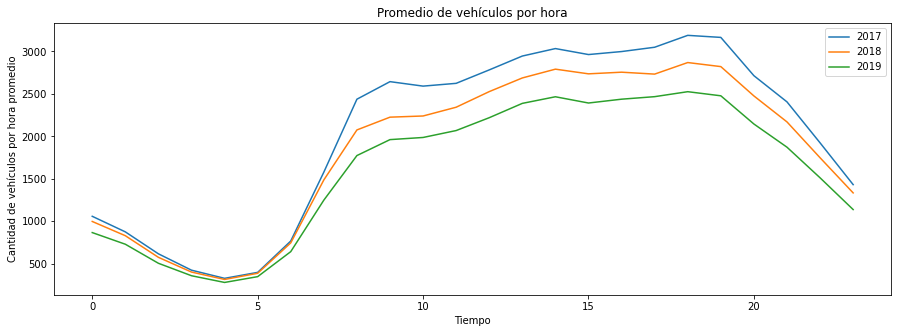

In [296]:
plt.figure(figsize = (15,5))
plt.plot(data02_2017.index, data02_2017.cantidad_pasos, label = '2017')
plt.plot(data02_2018.index, data02_2018.cantidad_pasos, label = '2018')
plt.plot(data02_2019.index, data02_2019.cantidad_pasos, label = '2019')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por hora promedio')
plt.legend()
plt.title("Promedio de vehículos por hora")
plt.show()

In [297]:
data02_2017.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
fecha_hora                
18             3188.217033
19             3164.079670
17             3048.282967
14             3032.713499
16             2997.561983
15             2962.280992
13             2944.735537
12             2781.606061
20             2713.387363
9              2643.371901
11             2623.439560
10             2590.710744
8              2436.694215
21             2405.151099
22             1923.011019
7              1578.074176
23             1431.212121
0              1058.443526
1               875.214876
6               767.447802
2               616.856749
3               424.277473
5               398.447802
4               328.315934

In [298]:
data02_2018.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
fecha_hora                
18             2868.113573
19             2820.415512
14             2790.307479
16             2754.606648
15             2735.310249
17             2732.113573
13             2686.850416
12             2526.077562
20             2475.105263
11             2342.326870
10             2239.193906
9              2225.290859
21             2169.340720
8              2074.855556
22             1747.491667
7              1486.363889
23             1333.775000
0               997.588889
1               830.030641
6               745.513889
2               575.505556
3               402.121884
5               387.663889
4               315.166667

In [299]:
data02_2019.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
fecha_hora                
18             2525.098901
19             2476.813187
17             2466.629121
14             2465.390110
16             2436.923077
15             2391.848901
13             2387.631868
12             2219.043956
20             2144.777473
11             2067.763085
10             1986.299451
9              1961.063187
21             1871.818681
8              1773.376374
22             1511.460055
7              1248.634615
23             1137.730028
0               866.834254
1               729.728532
6               642.530220
2               505.490358
3               358.939394
5               348.175824
4               279.925824

Text(0, 0.5, 'Cantidad de vehículos por hora promedio')

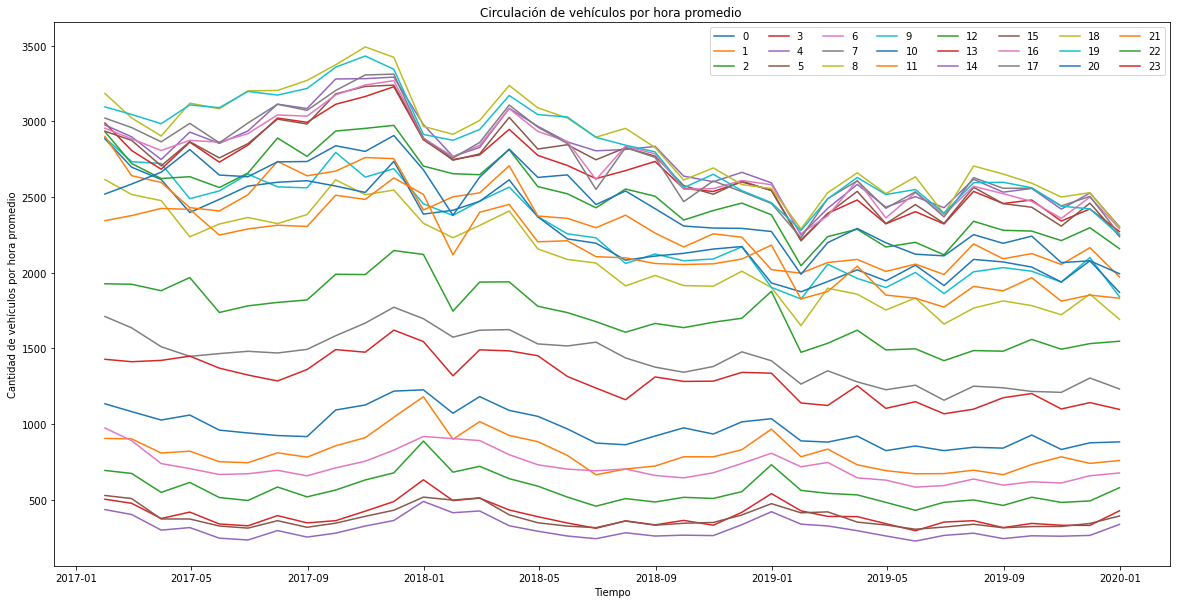

In [300]:
data02["fecha"] = pd.to_datetime(data02['fecha'])
data02=data02.groupby(by="fecha").sum()
data02["fecha_hora"]=data02.index.hour
plt.figure(figsize=(20,10))
for i in range (0,24):
    data=data02[data02.fecha_hora == i].resample("M").mean()
    plt.plot(data.index,data.cantidad_pasos,label=i)
plt.legend(loc="upper right", ncol=8)
plt.title("Circulación de vehículos por hora promedio ")
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por hora promedio')

Como se puede ver en la gráfica y en la tabla el horario con mayor circulación de vehículos que pagan en efectivo es a las 18hs.

#### Tratamiento valores atípicos o outliers

In [301]:
# Comenzamos con el dataset original y convirtiendo la variable fecha a formato datetime
data00.fecha=pd.to_datetime(data00.fecha)
data00

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

In [302]:
# Resampleamos a frecuencia horario
# Notar que ahora contaremos con 26280 (365días/año * 3años * 24hs/día = 26280 hs) filas en vez de 238869 como tenía el dataset crudo
# También al resamplear mediante la operación suma, perederemos la información contenida en las variables categóricas
data00_horaria = data00.resample('H', on = 'fecha').sum()
data00_horaria.describe()

cantidad_pasos
count    26280.000000
mean      1821.369140
std       1032.264551
min          0.000000
25%        856.000000
50%       1939.000000
75%       2685.000000
max       4412.000000

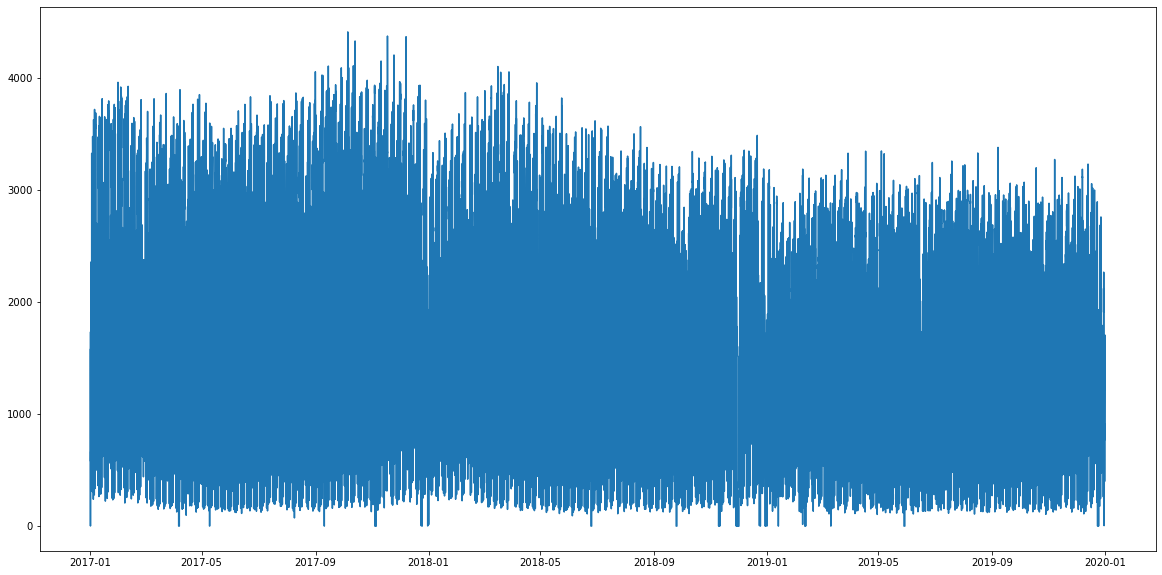

In [303]:
plt.subplots(figsize=(20,10))
plt.plot(data00_horaria)
plt.show()

In [304]:
# En los primeros gráficos cuando realizamos el EDA detectamos algunos outliers muy cercanos a 0 o incluso 0. 
# Para estos asignaremos un valor nulo o Nan a aquellos que se encuentren por debajo del percentil 2.5 y luego imputaremos su valor mediante interpolación.
np.percentile(data00_horaria, 2.5)

174.0

In [305]:
# De esta manera encontramos 652 valores que ahora serán imputados mediante interpolación.
data00_horaria.cantidad_pasos[data00_horaria.cantidad_pasos < np.percentile(data00_horaria, 2.5)] = np.nan
print(data00_horaria.isna().sum())

cantidad_pasos    652
dtype: int64


cantidad_pasos    0
dtype: int64


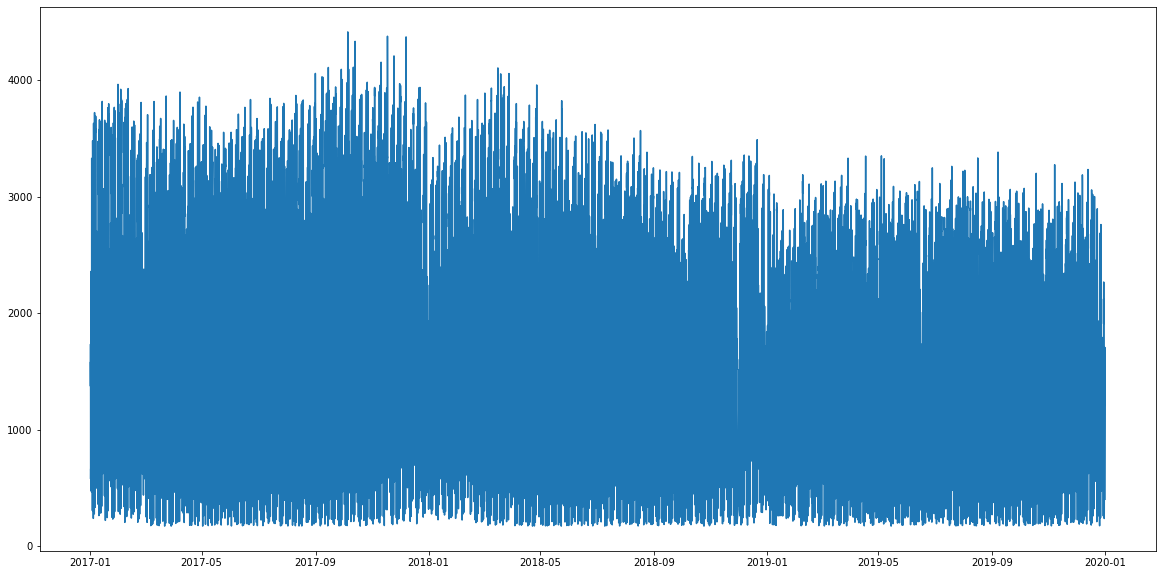

In [306]:
data00_horaria = data00_horaria.interpolate()
print(data00_horaria.isna().sum())
plt.subplots(figsize=(20,10))
plt.plot(data00_horaria)
plt.show()

In [307]:
# También vamos a resamplear nuestro dataset con frecuencia horaria a un dataset con frecuencia diaria para una mejor interpretabilidad de los datos. 
# Ahora tendremos 1095 filas (395 días/año * 3 años)
data00_diaria = data00_horaria.resample("D").sum()
data00_diaria

cantidad_pasos
fecha                     
2017-01-01         32657.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         22128.5

[1095 rows x 1 columns]

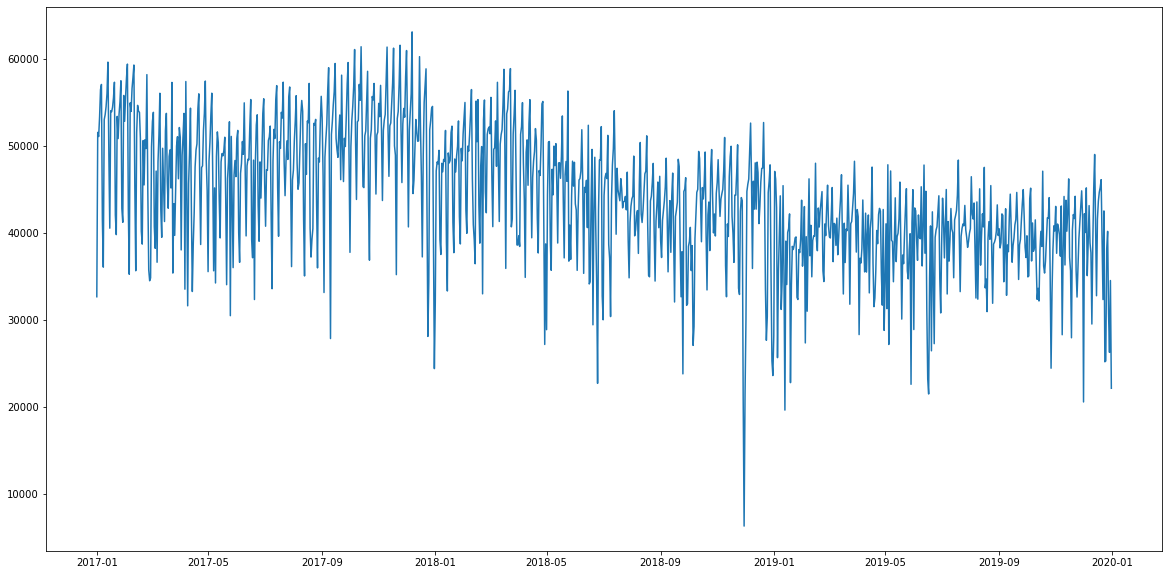

In [308]:
plt.subplots(figsize=(20,10))
plt.plot(data00_diaria.cantidad_pasos)
plt.show()

In [309]:
# Corregimos los outliers de la misma manera que lo hicimos anteriormente con la frecuencia horaria.
data00_diaria.cantidad_pasos[data00_diaria.cantidad_pasos < np.percentile(data00_diaria, 2.5)] = np.nan
print(data00_diaria.isna().sum())
data00_diaria = data00_diaria.interpolate()
print(data00_diaria.isna().sum())

cantidad_pasos    28
dtype: int64
cantidad_pasos    0
dtype: int64


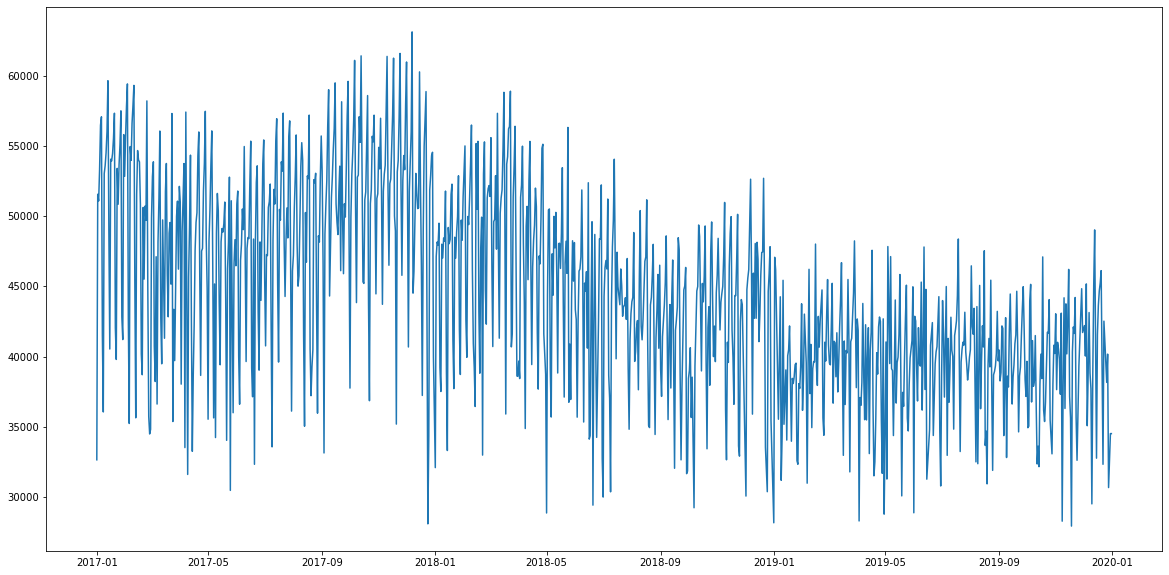

In [310]:
plt.subplots(figsize=(20,10))
plt.plot(data00_diaria.cantidad_pasos)
plt.show()

### Autocorrelación

La autocorrelación o dependencia secuencial es una herramienta estadística utilizada frecuentemente en el procesado de señales. La función de autocorrelación se define como la correlación cruzada de la señal consigo misma (Fuente:https://es.wikipedia.org/wiki/Autocorrelaci%C3%B3n).

Las gráficas de autocorrelación y de autocorrelación parcial resumen gráficamente la fuerza de una relación entre una observación de una serie de tiempo con observaciones anteriores de la misma serie de tiempo. Las observaciones con pasos de tiempo anteriores son llamadas lags.

Un gráfico de autocorrelación de una serie de tiempo se llama Función de Autocorrelación (ACF). También se lo llama a veces correlograma.
El gráfico muestra el valor de lag a lo largo del eje x y la correlación en el eje y entre -1 y 1.
Los intervalos de confianza se dibujan como un cono. Por defecto, se establece un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación y no una casualidad estadística.

(Fuente: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [311]:
nlags=40
autocorr=stattools.acf(data00_diaria.cantidad_pasos, nlags=nlags)
autocorr.shape
len(autocorr)

C:\Users\ferna\.conda\envs\datascience\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


41

Text(0.5, 0, 'lag')

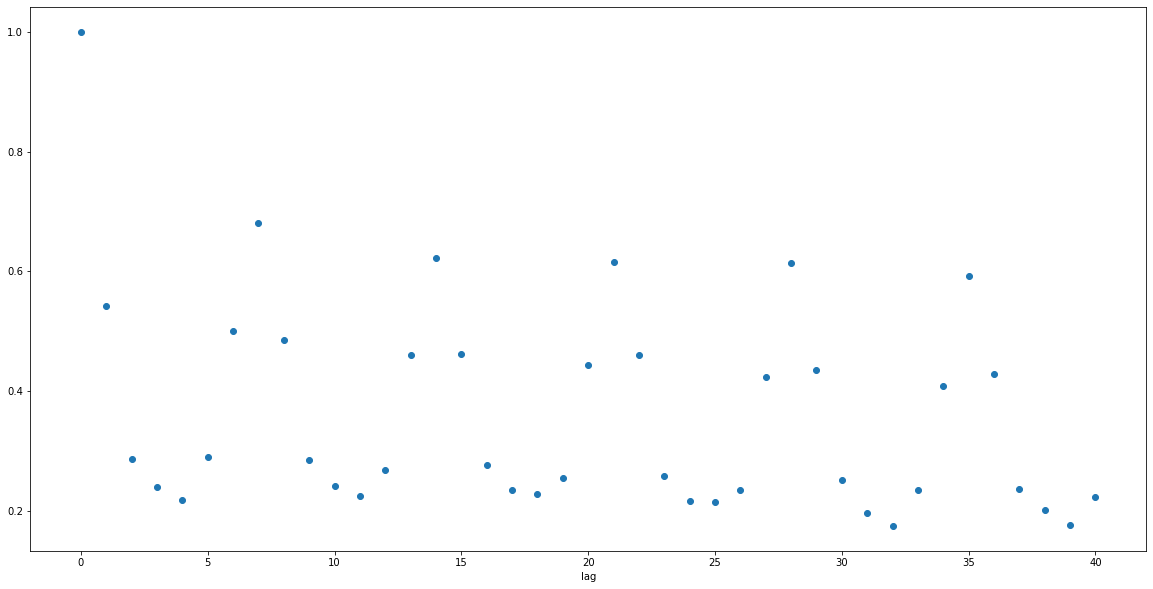

In [312]:
plt.figure(figsize = (20,10))
plt.scatter(np.arange(len(autocorr)), autocorr)
plt.xlabel('lag')

En el gráfico anterior podemos apreciar cierta autocorrelación positiva y también la aparición de un "patrón". Si prestamos atención al comportamiento de este patrón, notaremos que se repite cada 7 días lo que coincide con los 7 días de la semana. Entonces, puede apreciarse que la cantidad de vehículos que circulan un día está muy relacionada con la cantidad de vehículos que circularon ese mismo día la semana anterior y las anteriores pero siempre respetando el mismo día. También puede destacarse correlación con el día anterior elevada.

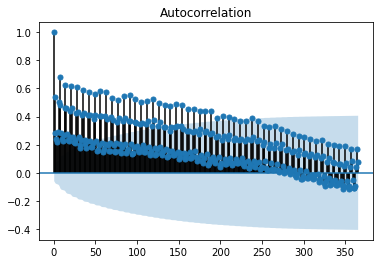

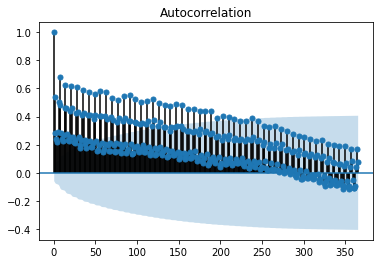

In [313]:
tsaplots.plot_acf(data00_diaria.cantidad_pasos,lags=365)

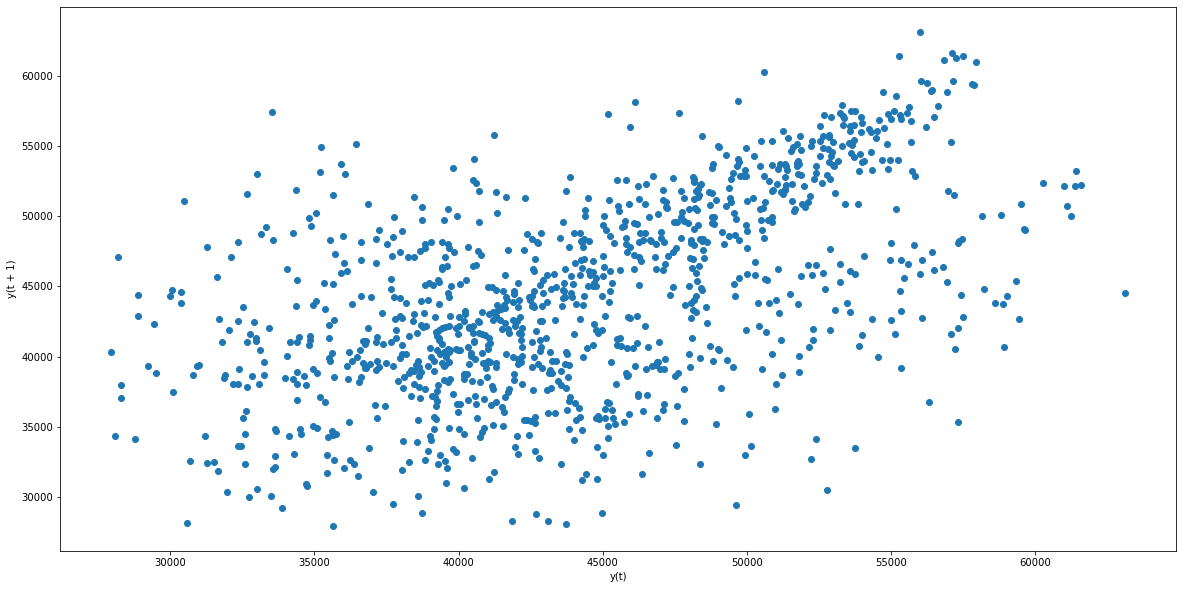

In [314]:
plt.figure(figsize=(20,10))
pd.plotting.lag_plot(data00_diaria.cantidad_pasos)

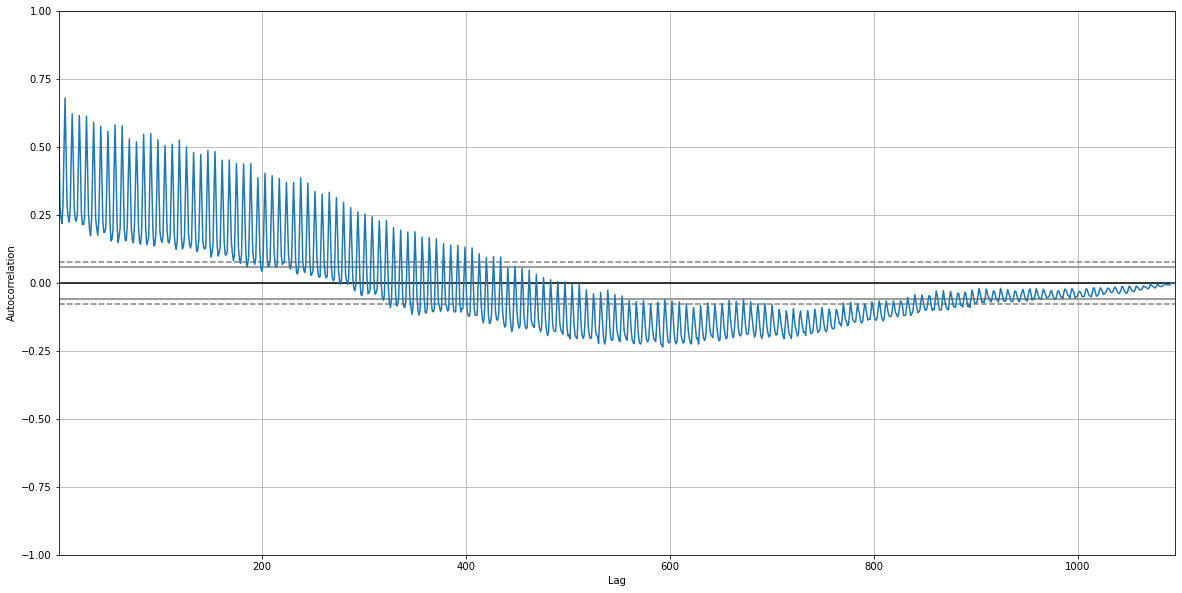

In [315]:
plt.figure(figsize=(20,10))
pd.plotting.autocorrelation_plot(data00_diaria.cantidad_pasos)

## Autocorrelación parcial
Una autocorrelación parcial es un resumen de la relación entre una observación en una serie temporal con observaciones en etapas anteriores, sin tener en cuenta las relaciones de las observaciones intermedias.

La autocorrelación parcial en el lag k es la correlación que resulta después de eliminar el efecto de cualquier correlación debida a los términos en lags intermedios.
La autocorrelación para una observación y una observación en un paso de tiempo anterior se compone tanto de la correlación directa como de las correlaciones indirectas. Estas correlaciones indirectas son una función lineal de la correlación de la observación, con observaciones en pasos de tiempo intermedios.

Son estas correlaciones indirectas las que la función de autocorrelación parcial busca eliminar.

(Fuente: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [316]:
nlags=20
autocorr_p=stattools.pacf(data00_diaria.cantidad_pasos, nlags=nlags)
autocorr_p.shape

(21,)

Text(0.5, 0, 'lag')

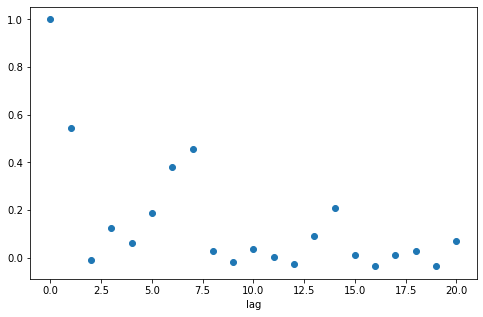

In [317]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(len(autocorr_p)), autocorr_p)
plt.xlabel('lag')

Sumado a lo que habíamos notado en el gráfico de autocorrelación anterior, aquí se reafirma nuestra sospecha de la autocorrelación con el mismo día de la semana anterior (lag 7), pero también notamos una interesante correlación con el día anterior (lag 1) y también con el lag 6. A modo de ejemplo, podemos decir que la cantidad de autos que pasaron el miércoles 18 de Diciembre de 2019 está correlacionada positivamente con la cantidad de autos que pasaron los días:
- Martes 17 de Diciembre de 2019 (lag 1)
- Miércoles 11 de Diciembre de 2019 (lag 7)
- Jueves 12 de Diciembre de 2019 (lag 6)

## Componentes de la serie de tiempo

### Técnica de la media móvil
Consiste en tomar una ventana de tiempo suficientemente grande y promediar la serie sobre esa ventana siendo posible de esta manera obtener la tendencia. Una característica de este método es que no asume ninguna forma para la serie de tiempo. 

In [318]:
ventana = int(1095/36)
ventana

30

In [319]:
data00_diaria_promedio_tendencia = data00_diaria.cantidad_pasos.rolling(window=ventana, center = True).mean()
data00_diaria_promedio_tendencia

fecha
2017-01-01   NaN
2017-01-02   NaN
2017-01-03   NaN
2017-01-04   NaN
2017-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

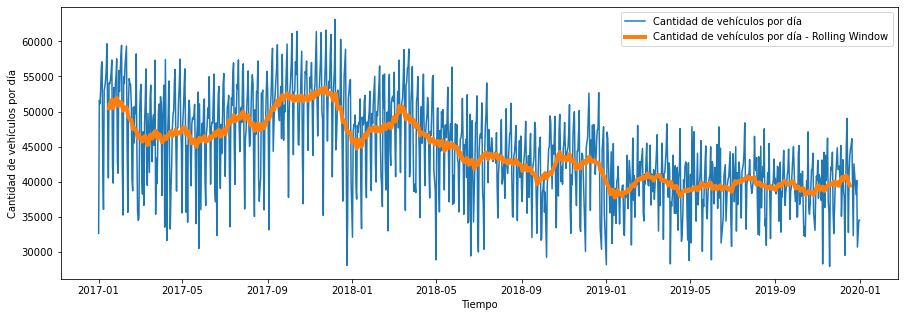

In [320]:
plt.figure(figsize = (15,5))
plt.plot(data00_diaria.index, data00_diaria.cantidad_pasos, label = 'Cantidad de vehículos por día')
plt.plot(data00_diaria_promedio_tendencia, lw = 4, label = 'Cantidad de vehículos por día - Rolling Window')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

### Técnica de la tendencia lineal
Este método consiste simplemente en ajustar una regresión lineal a la serie.

In [321]:
# Para comenzar, lo único que tenemos que tener en cuenta es que no podemos ajustar una regresión lineal con las fechas así como las tenemos,
# por lo que tenemos que pasarlas a un formato numérico.

In [322]:
data00_diaria['fecha_numeros']=data00_diaria.index.map(dt.datetime.toordinal)
data00_diaria

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-01         32657.0         736330
2017-01-02         51568.0         736331
2017-01-03         51093.0         736332
2017-01-04         53332.0         736333
2017-01-05         56486.0         736334
...                    ...            ...
2019-12-27         40182.0         737420
2019-12-28         30681.0         737421
2019-12-29         32602.0         737422
2019-12-30         34523.0         737423
2019-12-31         34523.0         737424

[1095 rows x 2 columns]

In [323]:
lr = LinearRegression()
lr.fit(data00_diaria.fecha_numeros.values.reshape(-1, 1), data00_diaria.cantidad_pasos)

LinearRegression()

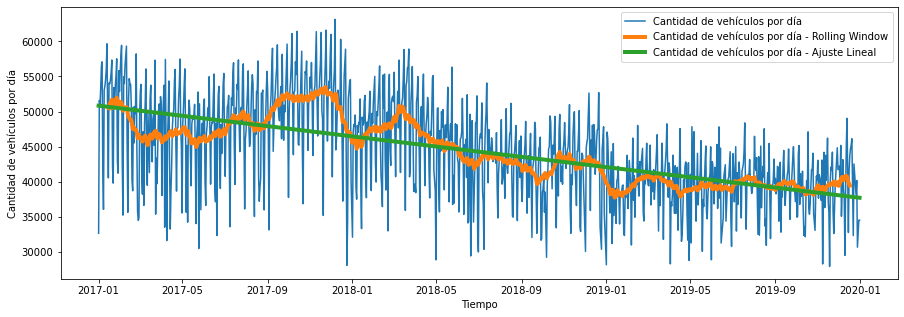

In [324]:
plt.figure(figsize = (15,5))
plt.plot(data00_diaria.index, data00_diaria.cantidad_pasos, label = 'Cantidad de vehículos por día')
plt.plot(data00_diaria_promedio_tendencia, lw = 4, label = 'Cantidad de vehículos por día - Rolling Window')
plt.plot(data00_diaria.index, lr.predict(data00_diaria.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de vehículos por día - Ajuste Lineal')
# plt.xlim(datetime.date(1985,1,1), datetime.date(2018,1,1))
# plt.ylim([0,30])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

Lo que se puede apreciar claramente en este gráfico es una marcada tendencia negativa en la cantidad de vehículos que circulan por este peaje abonando en efectivo con el pasar de los años.

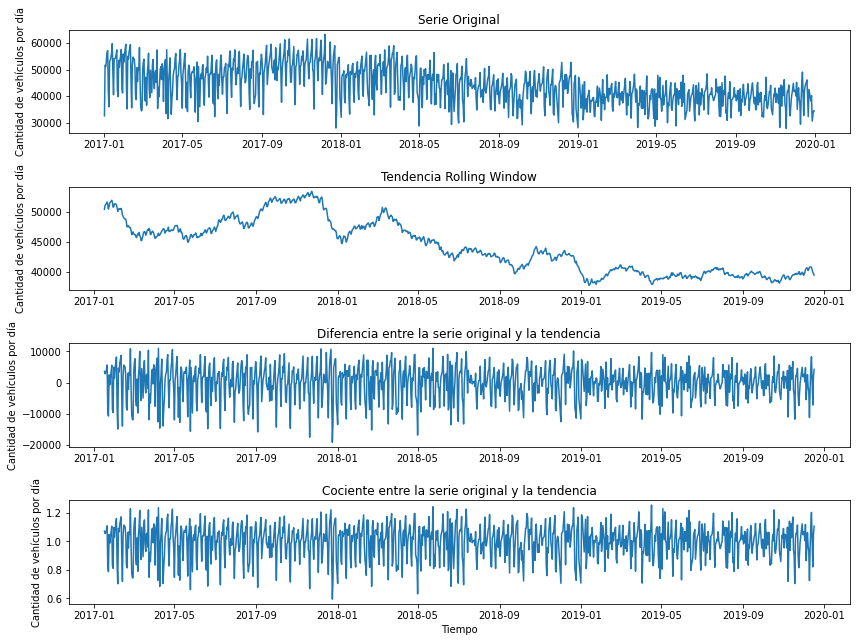

In [325]:
plt.figure(figsize = (12,9))

plt.subplot(4,1,1)
plt.title('Serie Original')
plt.plot(data00_diaria.index, data00_diaria.cantidad_pasos)
plt.ylabel('Cantidad de vehículos por día')

plt.subplot(4,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(data00_diaria_promedio_tendencia)
plt.ylabel('Cantidad de vehículos por día')

plt.subplot(4,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(data00_diaria.index, data00_diaria.cantidad_pasos - data00_diaria_promedio_tendencia)
plt.ylabel('Cantidad de vehículos por día')

plt.subplot(4,1,4)
plt.title('Cociente entre la serie original y la tendencia')
plt.plot(data00_diaria.index, data00_diaria.cantidad_pasos / data00_diaria_promedio_tendencia)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')

plt.tight_layout()
plt.show()

### Obtención de componentes mediante Statsmodels

Comportamiento aditivo de componentes ($Tendencia + Estacionalidad + Ruido$)

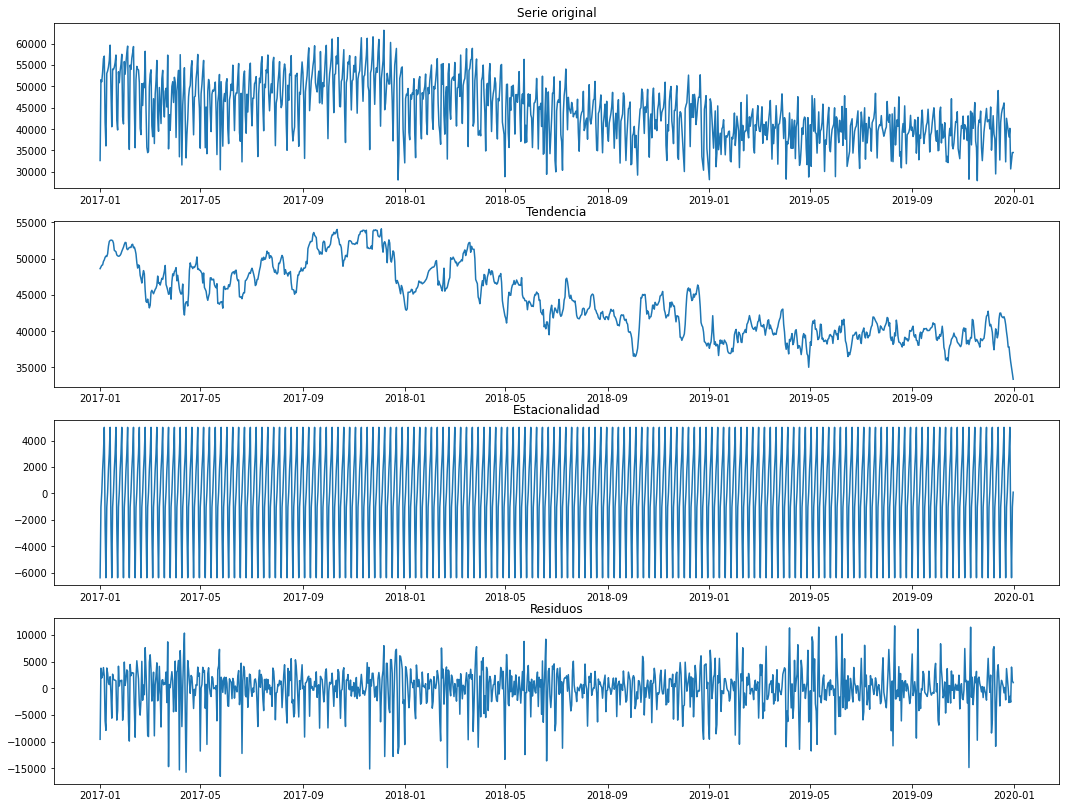

In [326]:
data00_diaria_decomposed_add = seasonal_decompose(data00_diaria.cantidad_pasos, model='additive', extrapolate_trend='freq')
plt.figure(figsize = (18,14))

plt.subplot(4,1,1)
plt.title('Serie original')
plt.plot(data00_diaria_decomposed_add.observed)

plt.subplot(4,1,2)
plt.title('Tendencia')
plt.plot(data00_diaria_decomposed_add.trend)

plt.subplot(4,1,3)
plt.title('Estacionalidad')
plt.plot(data00_diaria_decomposed_add.seasonal)

plt.subplot(4,1,4)
plt.title('Residuos')
plt.plot(data00_diaria_decomposed_add.resid)

plt.show()

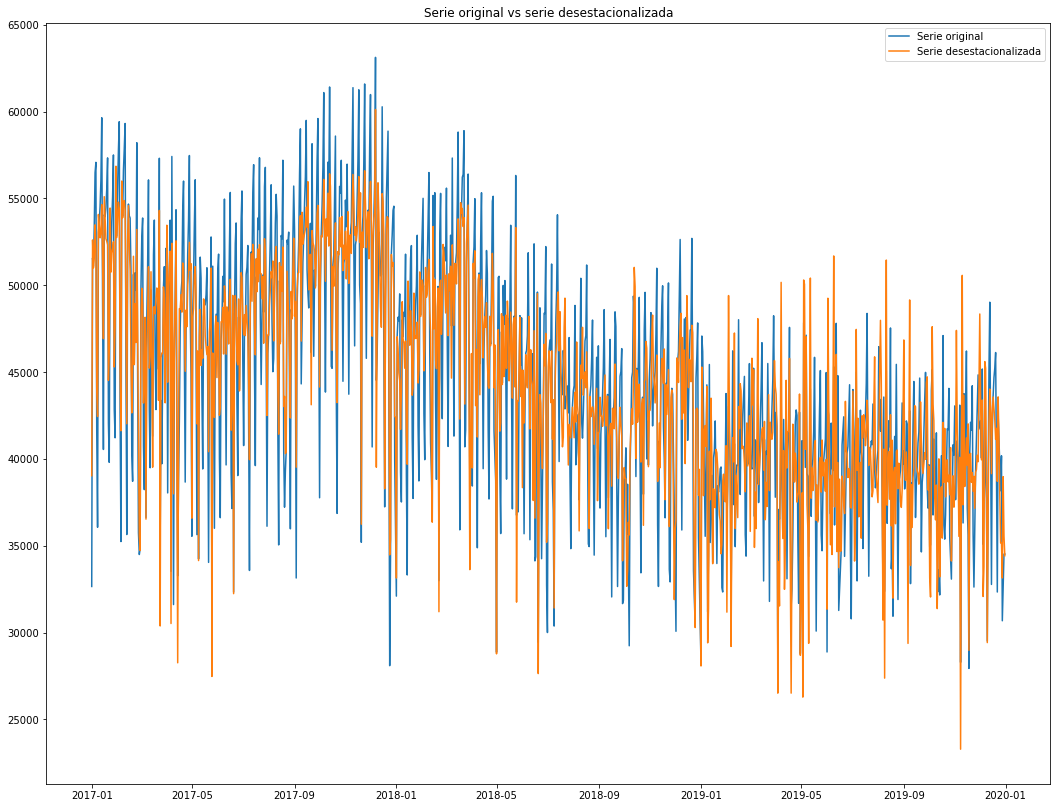

In [327]:
# Serie desetacionalizada
plt.figure(figsize = (18,14))
plt.plot(data00_diaria_decomposed_add.observed, label = "Serie original")
plt.plot(data00_diaria_decomposed_add.observed - data00_diaria_decomposed_add.seasonal, label = "Serie desestacionalizada")
plt.title("Serie original vs serie desestacionalizada")
plt.legend()

Comportamiento multiplicativo de componentes ($Tendencia * Estacionalidad * Ruido$)

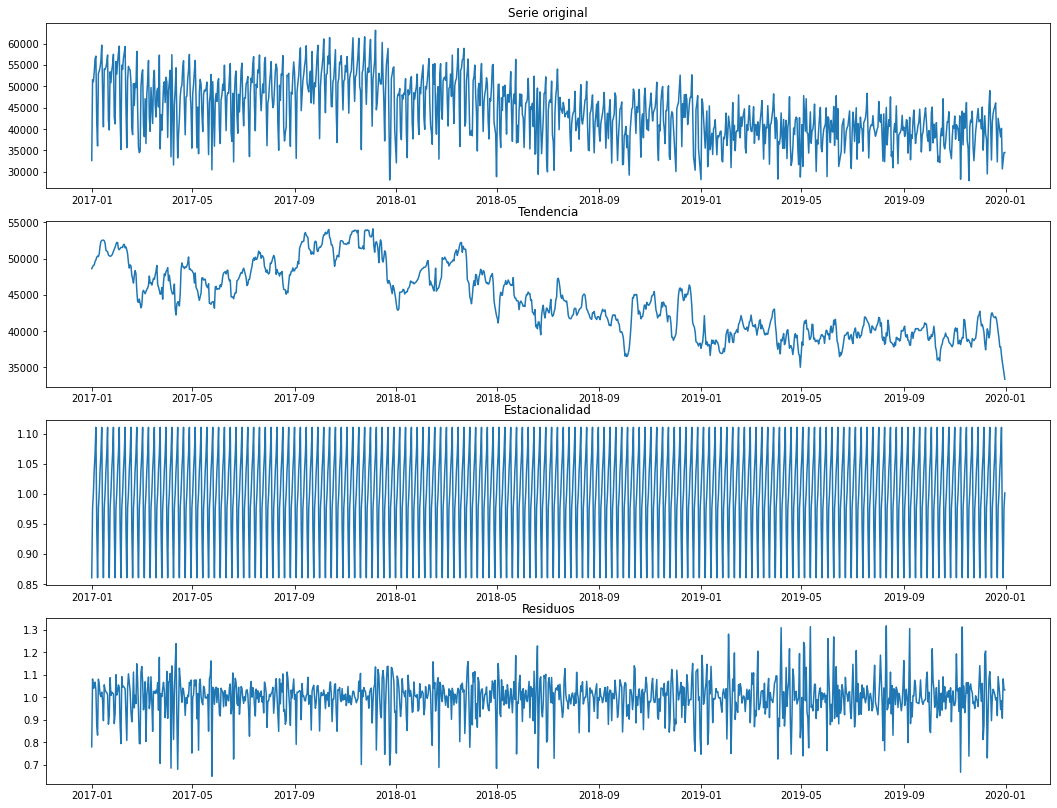

In [328]:
data00_diaria_decomposed_mul = seasonal_decompose(data00_diaria.cantidad_pasos, model='multiplicative', extrapolate_trend='freq')
plt.figure(figsize = (18,14))

plt.subplot(4,1,1)
plt.title('Serie original')
plt.plot(data00_diaria_decomposed_mul.observed)

plt.subplot(4,1,2)
plt.title('Tendencia')
plt.plot(data00_diaria_decomposed_mul.trend)

plt.subplot(4,1,3)
plt.title('Estacionalidad')
plt.plot(data00_diaria_decomposed_mul.seasonal)

plt.subplot(4,1,4)
plt.title('Residuos')
plt.plot(data00_diaria_decomposed_mul.resid)

plt.show()

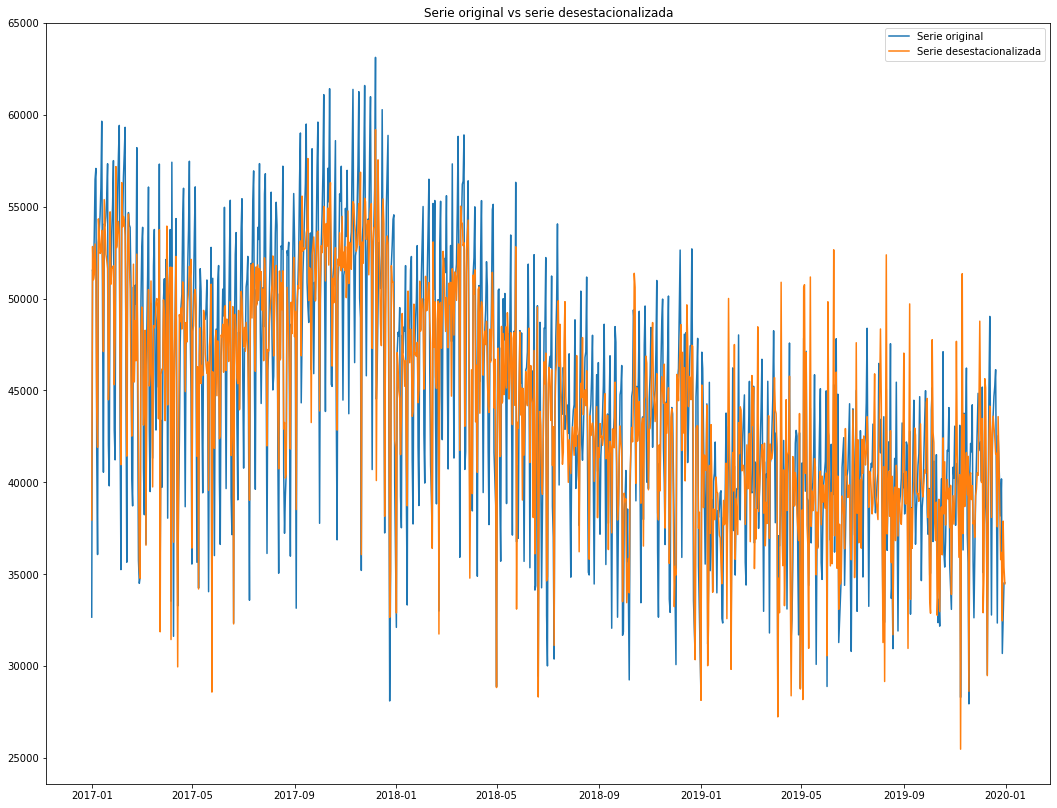

In [329]:
# Serie desestacionalizada
plt.figure(figsize = (18,14))
plt.plot(data00_diaria_decomposed_mul.observed, label = "Serie original")
plt.plot(data00_diaria_decomposed_mul.observed / data00_diaria_decomposed_mul.seasonal, label = "Serie desestacionalizada")
plt.title("Serie original vs serie desestacionalizada")
plt.legend()

La descomposición aditiva es la más adecuada cuando no se tienen cambios significativos en la magnitud de las fluctuaciones del componente estacional. Si ese fuese el caso, entonces la descomposición multiplicativa sería la indicada. En nuestro proyecto, no observamos grandes cambios en este componente por lo que utilizaremos la descomposición aditiva. 

### Predicción a Futuro


Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados? **Exploraré esta opción luego, no será tenido en cuenta para el alcance de este proyecto.**

Como vimos anteriormente en nuestro EDA, las variables categóricas no tenían una gran influencia o por el momento no identificamos potencial necesario en ellas para que sean tenidas en cuenta al momento de elaborar una predicción futura en la cantidad de vehículos que pagarán en efectivo en la estación Illia.

De esta manera, utilizando solo la información pasada como variable nos enfocaremos a realizar una Predicción univariada de nuestra serie de tiempo. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.

In [330]:
# Utilizaremos el dataset  data00_diaria y data00_horaria ya que son datasets que ya resampleamos a sus frecuencias correspondientes 
# y también ya trabajamos sus valores atípicos.
# Por el momento, no se manifiesta una necesidad particular de hacer alguna trasnformación adicional a los datasets.

In [331]:
data00_diaria2= data00_diaria.drop(columns="fecha_numeros")
data00_diaria2.to_csv("data00_diaria2.csv", index=False)
data00_diaria2

cantidad_pasos
fecha                     
2017-01-01         32657.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         32602.0
2019-12-30         34523.0
2019-12-31         34523.0

[1095 rows x 1 columns]

In [332]:
data00_horaria.to_csv("data00_horaria.csv",index=False)
data00_horaria

cantidad_pasos
fecha                              
2017-01-01 00:00:00          1576.0
2017-01-01 01:00:00          1475.0
2017-01-01 02:00:00          1374.0
2017-01-01 03:00:00          1734.0
2017-01-01 04:00:00          1247.0
...                             ...
2019-12-31 19:00:00          1217.0
2019-12-31 20:00:00          1374.0
2019-12-31 21:00:00          1706.0
2019-12-31 22:00:00          1139.0
2019-12-31 23:00:00           404.0

[26280 rows x 1 columns]

2. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.

La métrica que vamos a utilizar para evaluar los distintos modelos son el error absoluto medio (Mean Absolute Error) y la raíz del error cuadrático medio (RMSE). Estas métricas son dos de las más populares utilizadas para algoritmos de regresión.

Además el MAE tiene la particularidad de ser muy fácil de interpretar y entender y por otro lado el RMSE tiene la particularidad de representar la desviación estándard de los residuos (y_real-y_predicho) penalizando así más aquellas diferencias muy grandes que podrían pasar desapercibidas en el MAE.

Como métrica adicional utilizada generalmente en series de tiempo, prestaremos atención al MAPE (Error porcentual absoluto medio) que esta definido por la fórmula: 

\begin{equation}
MAPE=\frac{100%}{n}\sum_{i=0}^n\frac{y_{i}-\hat{y}}{y_{i}}
\end{equation}

3. Elige un modelo benchmark y compara tus resultados con este modelo.

Utilizaremos los dos y medio primeros años como conjunto de entrenamiento. Y el medio año restante como evaluación. Para ello, tenemos que llevar los datos a la forma siguiente:

In [333]:
# Pasamos el dataset a objeto Serie
serie=data00_diaria2.cantidad_pasos
serie.head()

fecha
2017-01-01    32657.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [334]:
# En primer lugar, debemos definir cuántos valores hacia atrás tomaremos.
look_back=365
N=serie.shape[0]
N

1095

In [335]:
# Definimos X e Y
X = np.zeros((N - look_back - 1,look_back)) # Lo que estamos haciendo es crear una fila en X con 365 valores para cada fila en Y que vamos a predecir
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(729, 365) (729,)


In [336]:
# LLenamos los X e y
for i in range(X.shape[0]): #X.shape[0] es la cantidad de valores a pronosticar que es igual a y.shape[0], es decir, 729.
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = serie.iloc[i:i+look_back]
    y[i] = serie.iloc[i+look_back]

In [337]:
#print(X)

In [338]:
#print(y)

In [339]:
N_train = 913 - look_back # cantidad de instancias que vamos a usar para entrenar (365*2.5=913). 
N_test = 182 #cantidad de puntos que vamos a usar para evaluar (365*0.5=182).
N_total = N_train + N_test

length_total = N_train + N_test + look_back
length_total

1095

In [340]:
# Hacemos el train/test split.
X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(548, 365) (548,)
(181, 365) (181,)


#### Modelo Benchmark
Como modelo base para comparar o benchmark simplmente predecíremos los valores de y copiando el valor de la fecha anterior. Vale aclarar que aquí estamos haciendo one-step prediction, es decir, que estamos prediciendo un valor a la vez y no un conjunto o secuencia de valores que sería multi-step prediction

In [341]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 2]
print(y_test_pred_benchmark.shape)
y_test_pred_benchmark

(181,)


array([43996.        , 41613.        , 37124.        , 41016.        ,
       44995.        , 32975.        , 41301.        , 36759.        ,
       39193.        , 42809.        , 40438.        , 40021.        ,
       34842.        , 41502.        , 41978.        , 42552.5       ,
       44333.5       , 48381.        , 39900.        , 33247.        ,
       39618.        , 40523.        , 41030.5       , 40821.5       ,
       43164.        , 40348.        , 39500.        , 38338.        ,
       39029.        , 39964.        , 40493.        , 46468.        ,
       42150.        , 41603.        , 43445.        , 38276.        ,
       32510.        , 43566.        , 32379.        , 39114.        ,
       45075.        , 36295.        , 39662.        , 42198.        ,
       40689.5       , 47543.        , 33680.        , 34702.        ,
       30943.        , 39330.        , 41298.        , 39273.        ,
       45447.        , 38050.        , 31905.        , 38712.        ,
      

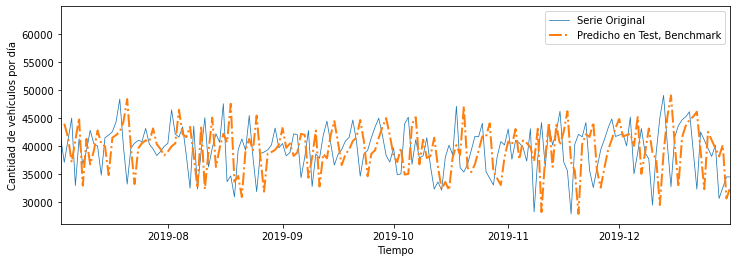

In [342]:
plt.figure(figsize=(12,4))
plt.plot(serie.index[:length_total], serie[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(serie.index[N_train+look_back+1: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(serie.index[N_train+look_back], serie.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

In [2]:
# Métrica MAPE tomada de https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [344]:
RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred_benchmark))
MAE = mean_absolute_error(y_test, y_test_pred_benchmark)
MAPE = mape_vectorized_v2(y_test,y_test_pred_benchmark)
print("RMSE",RMSE)
print("MAE", MAE)
print("MAPE", MAPE)

RMSE 5067.595419262802
MAE 3954.1215469613257
MAPE 0.10392065086885131


4. Optimiza los hiperparámetros de tu modelo.

Evaluaremos varios modelos de ML con sus hiperparámetros genéricos y luego, optimizaremos los hiperparámetros de aquel que mejor se comporte con nuestros datos. También vale mencionar que a diferencia del modelo utilizado para Benchmark en el que se ejecutó una One-Step Prediction, en este caso estaremos realizando una Multi-Step Prediction

In [345]:
# Instanciamos y entrenamos varios modelos con el conjunto de train ya definido anteriormente:
LinReg=LinearRegression()
RF_reg=RandomForestRegressor()
LGBM=LGBMRegressor()
XGB=XGBRegressor()

LinReg.fit(X_train,y_train)
RF_reg.fit(X_train,y_train)
LGBM.fit(X_train,y_train)
XGB.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [346]:
# Función para hacer una predicción multi-step
def pred_model_time_series_multi_step(model,X_test,y_test):

    y_ms_test_pred = []
    x = X_test[0,:] # arrancamos con la primera instancia del conjunto de test
    for i in range(y_test.size):
        y_os_pred = model.predict(x.reshape(1,-1))
        y_ms_test_pred.append(y_os_pred)
        x = np.append(x[1:], y_os_pred)
    y_ms_test_pred = np.array(y_ms_test_pred)
    return y_ms_test_pred

In [347]:
def eva_model(y_train,y_train_pred,y_test,y_test_pred):

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test =  np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    mape_train = mape_vectorized_v2(y_train,y_train_pred)
    mape_test = mape_vectorized_v2(y_test,y_test_pred)
    
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Test: {rmse_test}')

    print(f'MAE Train: {mae_train}')
    print(f'MAE Test: {mae_test}')
    
    print(f'MAPE Train: {mape_train}')
    print(f'MAPE Test: {mape_test}')    
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    
    
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.tight_layout()
    plt.show()

LinReg
RMSE Train: 2522.5796664423474
RMSE Test: 5980.046999088325
MAE Train: 2004.6200558618734
MAE Test: 4841.850239700127
MAPE Train: 0.048920222250676194
MAPE Test: 0.1290841751072166


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


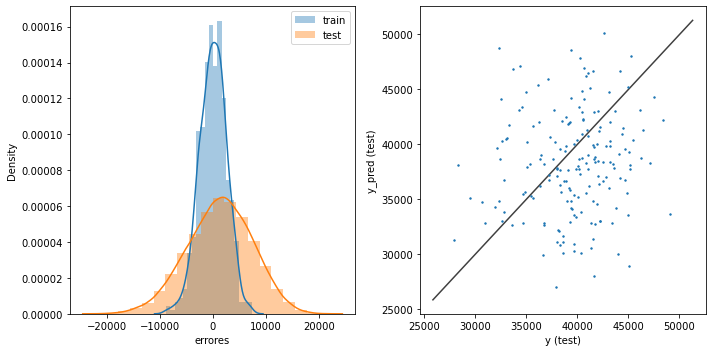

RF_reg
RMSE Train: 1584.398258339879
RMSE Test: 3812.986452885218
MAE Train: 1180.6127159367397
MAE Test: 3029.175727440148
MAPE Train: 0.02943771660554044
MAPE Test: 0.08665976963481868


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


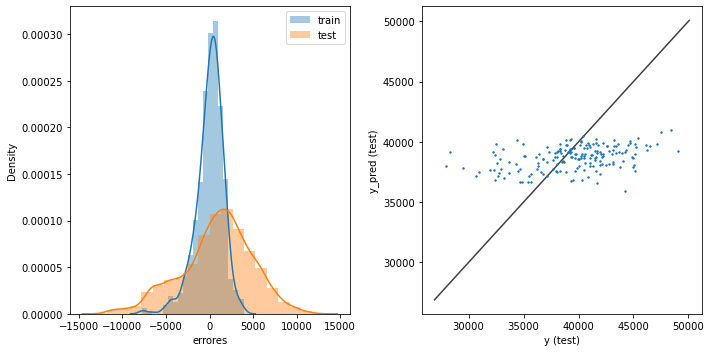

LGBM
RMSE Train: 469.80394571798087
RMSE Test: 4319.571288611163
MAE Train: 204.78880592736897
MAE Test: 3513.3165735963184
MAPE Train: 0.005289156442521926
MAPE Test: 0.09776494984957032


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


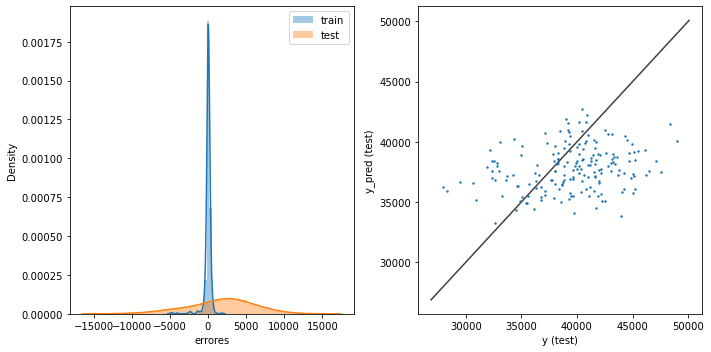

XGB
RMSE Train: 3.9260602088738628
RMSE Test: 4653.647601516853
MAE Train: 3.153167056341234
MAE Test: 3704.357432665746
MAPE Train: 7.52253909798493e-05
MAPE Test: 0.10327436390900994


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


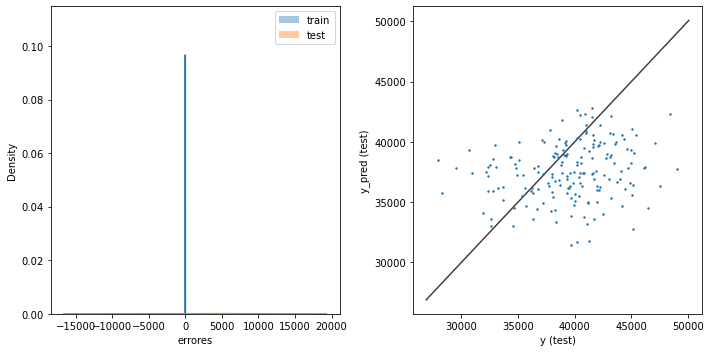

In [348]:
models = [('LinReg', LinReg),('RF_reg', RF_reg), ('LGBM', LGBM),('XGB', XGB)]
for name, model in models:
    print(name)
    y_train_pred = model.predict(X_train)
    y_pred_test=pred_model_time_series_multi_step(model,X_test,y_test)
    eva_model(y_train,y_train_pred,y_test,y_pred_test)

Como puede apreciarse en las gráficas y en las métricas evaluadas, uno de los algoritmos o modelos que mejor desempeño demostró es el de Random Forest. Los algoritmos de LightGBM y XGBoost tuvieron demuestran una performance similar en los sets de Test y un exageradamente buen desempeño en Train lo que indica un claro sobreajuste del modelo (overfitting).

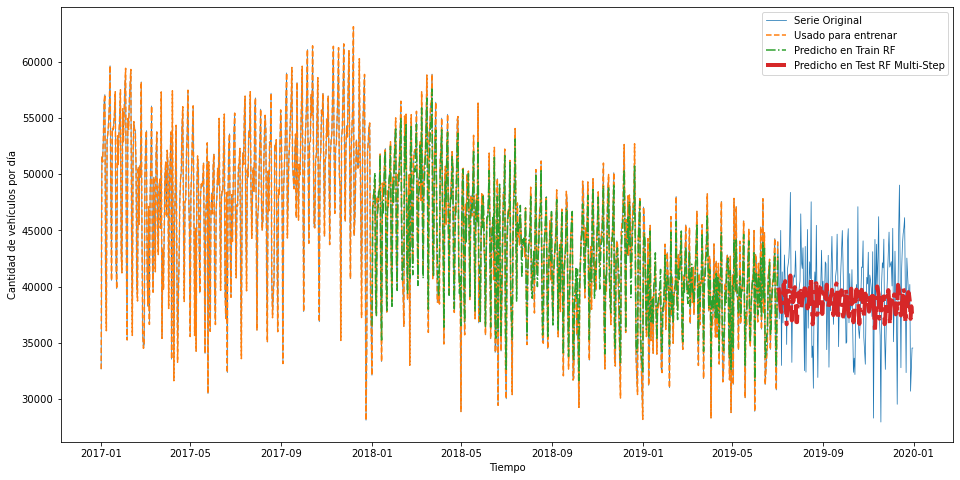

In [349]:
y_train_pred_RF=RF_reg.predict(X_train)
y_test_pred_RF = pred_model_time_series_multi_step(RF_reg,X_test,y_test)

plt.figure(figsize=(16,8))
plt.plot(serie.index[:length_total], serie[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(serie.index[:N_train + look_back], serie[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(serie.index[look_back: look_back + N_train], y_train_pred_RF,'-.',label = 'Predicho en Train RF')
plt.plot(serie.index[N_train+look_back: length_total-1], y_test_pred_RF,'-.', lw = 4, label = 'Predicho en Test RF Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.show()



Procederemos a optimizar los hiperparámetros del modelo de RandomForest. En este caso al tratarse de una serie de tiempo, hay que tener cuidado al hacer CrossValidation, ya que los subconjuntos en que dividamos nuestro conjunto de Train no pueden estar compuestos por datos seleccionados aleatoriamente, sino que deben ser un conjunto de datos con fechas contiguas. Para esto usaremos TimeSeriesSplit de Sklearn.

In [350]:
# Implementación tomada de https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

time_split = TimeSeriesSplit(n_splits=10)
# Veamos cómo quedaron conformados estos subconjuntos dentro de Train. 
# Tenemos 10 subconjuntos, dónde cada uno tiene 49 instancias de Test y sus conjuntos de Train van tomando los conjuntos Train y Test anteriores.
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((58,), (49,)),
 ((107,), (49,)),
 ((156,), (49,)),
 ((205,), (49,)),
 ((254,), (49,)),
 ((303,), (49,)),
 ((352,), (49,)),
 ((401,), (49,)),
 ((450,), (49,)),
 ((499,), (49,))]

In [351]:
rf = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=time_split, scoring='neg_mean_squared_error', n_jobs=1)

In [352]:
cv_scores, cv_scores.mean()

(array([-24114763.56502347, -26168054.16147041, -25931834.00490459,
         -6638151.79736837, -17525229.64130102, -18925477.53049528,
        -29522832.30207498,  -9791072.66194652, -26933207.34958476,
        -15887490.31578944]),
 -20143811.332995884)

In [353]:
np.sqrt(-cv_scores.mean())

4488.1857507233235

In [354]:
grid = {'n_estimators':(10, 50, 100, 150, 200, 250, 300,500,1000), 'max_depth':(2,5,None)}
rf_rdm_searcher = RandomizedSearchCV(estimator=rf, param_distributions=grid, scoring='neg_mean_squared_error', n_jobs=1, cv=time_split, verbose=1)

In [355]:
%%time
rf_rdm_searcher.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.1min finished


Wall time: 8min 17s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=1,
                   param_distributions={'max_depth': (2, 5, None),
                                        'n_estimators': (10, 50, 100, 150, 200,
                                                         250, 300, 500, 1000)},
                   scoring='neg_mean_squared_error', verbose=1)

In [356]:
rf_rdm_searcher.best_score_, rf_rdm_searcher.best_params_

(-20303753.460308157, {'n_estimators': 150, 'max_depth': None})

Vemos que los mejores parámetros son 300 estimadores y la profundidad de cada rama sin limitar.

RMSE Train: 1543.5197907537047
RMSE Test: 3770.3580075440277
MAE Train: 1158.680385239254
MAE Test: 2983.133175260896
MAPE Train: 0.028785177754893605
MAPE Test: 0.08697260975496443


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


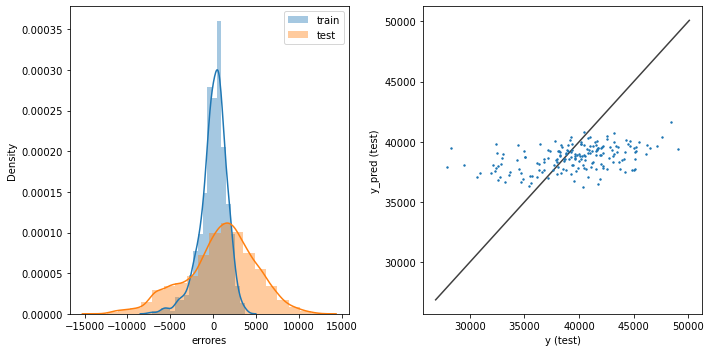

In [357]:
rf_optimized= RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42, n_jobs = 1)
rf_optimized.fit(X_train,y_train)
y_train_pred_RF_opti=rf_optimized.predict(X_train)
y_test_pred_RF_opti = pred_model_time_series_multi_step(rf_optimized,X_test,y_test)
eva_model(y_train,y_train_pred_RF_opti,y_test,y_test_pred_RF_opti)

Notamos que las métricas mejorar un poco respecto a los valores antes obtenidos con parámetros distintos.

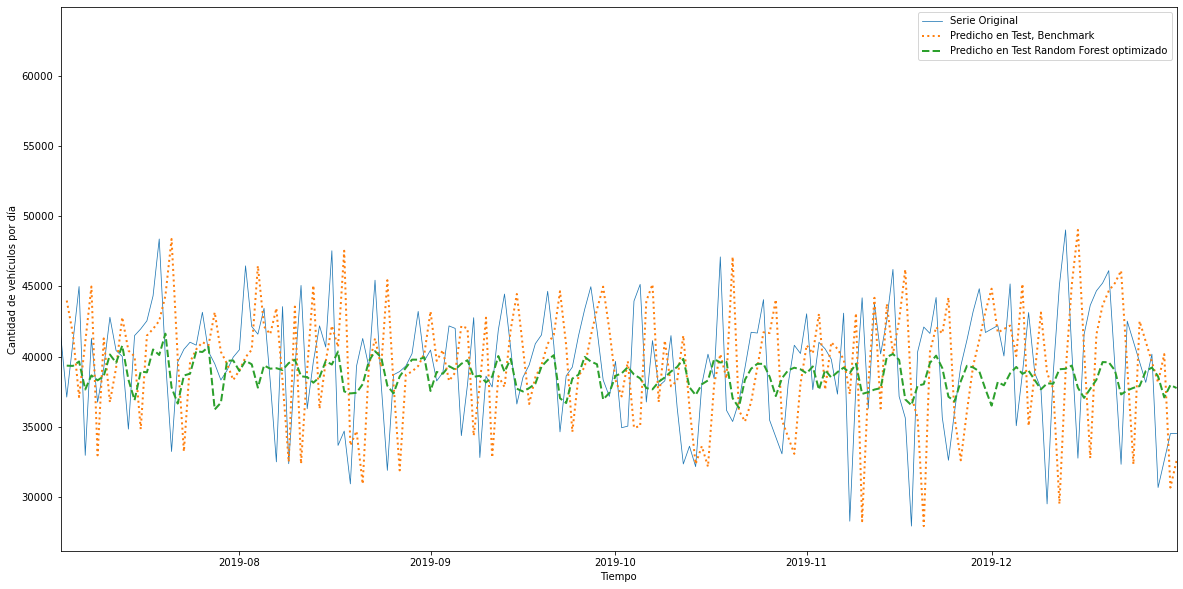

In [358]:
plt.figure(figsize=(20,10))
plt.plot(serie.index[:length_total], serie[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(serie.index[N_train+look_back+1: length_total], y_test_pred_benchmark,':', lw = 2, label = 'Predicho en Test, Benchmark')
plt.plot(serie.index[N_train+look_back+1: length_total], y_test_pred_RF_opti,'--', lw = 2, label = 'Predicho en Test Random Forest optimizado')
plt.xlim(serie.index[N_train+look_back], serie.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

5. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

En este caso al haber realizado un pronóstico de tipo univariado, la única información que está utilizando el modelo para predecir es la información de fechas anteriores a la que se está prediciedo. Si estuviésemos realizando un pronóstico de tipo multivariado, entonces sí estarían involucradas disntitas variables en la formación de la predicción y podríamos evaluar el peso de cada una de ellas.

De todas maneras, en nuestro conjunto X tenemos 365 features o variables, es decir el valor de cada uno de los 365 días anteriores al día que queremos predecir. Analizaremos qué días influyen más.

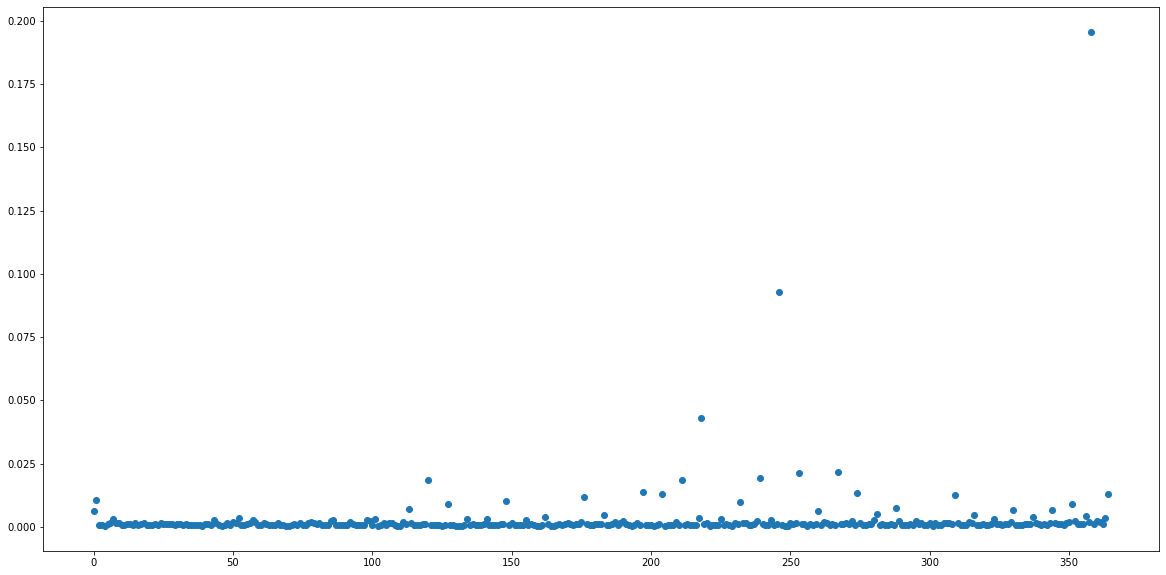

In [359]:
plt.figure(figsize = (20,10))
plt.scatter(np.arange(rf_optimized.feature_importances_.size),rf_optimized.feature_importances_)
plt.show()

In [360]:
feat_imp=pd.DataFrame(rf_optimized.feature_importances_).sort_values(by=0,ascending=False)
feat_imp

0
358  0.195588
246  0.092810
218  0.043028
267  0.021575
253  0.021440
..        ...
221  0.000396
130  0.000395
46   0.000391
201  0.000350
109  0.000334

[365 rows x 1 columns]

Coincidiendo con lo que habíamos analizado anteriormente con la autocorrelación y autocorrelación parcial, una de las variables más importantes al intentar predecir la cantidad de vehículos que pasaran por este peaje, es la cantidad de vehículos que pasaron por ese peaje hace 7 días, es decir, el mismo día de la semana anterior.

6. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?

En el caso de las series de tiempo, cada vez que se quiera hacer una nueva predicción es importante re entrenar el modelo agregando los nuevos datos. En este caso, re entrenaremos el modelo considerando los 3 años de datos que tenemos.

In [361]:
# Generamos una serie con datos vacíos para todo el año 2020
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2020, 12, 31)
index = pd.date_range(start, end)

s2020=pd.Series(np.zeros(366))
s2020.index=index
s2020

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
             ... 
2020-12-27    0.0
2020-12-28    0.0
2020-12-29    0.0
2020-12-30    0.0
2020-12-31    0.0
Freq: D, Length: 366, dtype: float64

In [362]:
# Agregamos estos datos a nuestra serie original que tenía los datos de los años 2017,2018 y 2019.
serie2020=serie.append(s2020)
serie2020

2017-01-01    32657.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2020-12-27        0.0
2020-12-28        0.0
2020-12-29        0.0
2020-12-30        0.0
2020-12-31        0.0
Freq: D, Length: 1461, dtype: float64

In [363]:
look_back2020=365 #Vamos a usar un año de datos anteriores para predecir
N2020=serie2020.shape[0] #El total de N que tendremos será la serie que acabamos de crear.
N2020

1461

In [364]:
# Definimos X e Y
X2020 = np.zeros((N2020 - look_back2020 - 1,look_back2020)) # Lo que estamos haciendo es crear una fila en X con 365 valores para cada fila en Y que vamos a predecir
y2020 = np.zeros(N2020 - look_back2020 - 1)
print(X2020.shape, y2020.shape)

(1095, 365) (1095,)


In [365]:
# LLenamos los X e y
for i in range(X2020.shape[0]): #X.shape[0] es la cantidad de valores a pronosticar que es igual a y.shape[0], es decir, 1094.
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X2020[i,:] = serie2020.iloc[i:i+look_back2020]
    y2020[i] = serie2020.iloc[i+look_back2020]

In [366]:
N_train2020=len(serie)-look_back2020 #Para entrenar vamos a utilizar los 3 años completos de datos
N_train2020

730

In [367]:
N_test2020 = len(s2020)
N_test2020

366

In [368]:
N_total2020 = N_train2020 + N_test2020
N_total2020

1096

In [369]:
length_total2020 = N_train2020 + N_test2020 + look_back2020
length_total2020

1461

In [370]:
# Hacemos el train/test split.
X_train2020 = X2020[:N_train2020,:]
y_train2020 = y2020[:N_train2020]
print(X_train2020.shape, y_train2020.shape)

X_test2020 = X2020[N_train2020:N_train2020+N_test2020,:]
y_test2020 = y2020[N_train2020:N_train2020+N_test2020]
print(X_test2020.shape, y_test2020.shape)

(730, 365) (730,)
(365, 365) (365,)


In [371]:
rf_2020= RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs = 1)
rf_2020.fit(X_train2020,y_train2020)
y_train_pred_RF2020=rf_2020.predict(X_train2020)

In [372]:
y_ms_test_pred2020 = []
x2020 = X_test2020[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test2020.size):
    y_os_pred2020 = rf_2020.predict(x2020.reshape(1,-1))
    y_ms_test_pred2020.append(y_os_pred2020)
    x2020 = np.append(x2020[1:], y_os_pred2020)
y_ms_test_pred2020 = np.array(y_ms_test_pred2020)

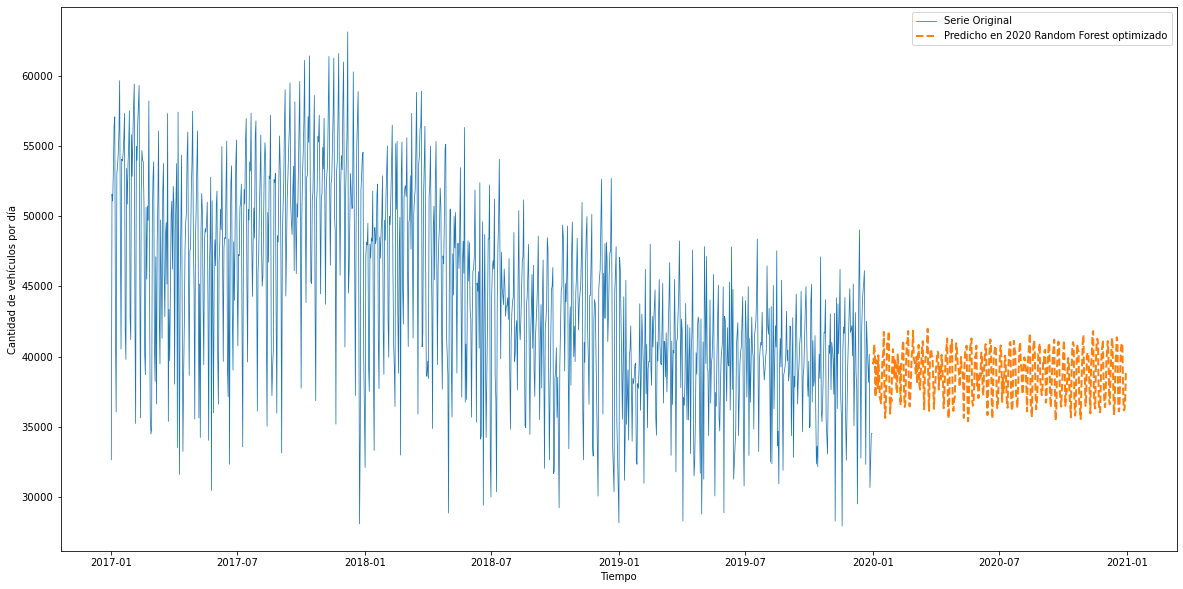

In [373]:
plt.figure(figsize=(20,10))
plt.plot(serie2020.index[:N_train2020+look_back2020], serie2020[:N_train2020+look_back2020],lw = 0.75, label = 'Serie Original')
plt.plot(serie2020.index[N_train2020+look_back2020: length_total2020-1], y_ms_test_pred2020,'--', lw = 2, label = 'Predicho en 2020 Random Forest optimizado')
#plt.xlim(serie2020.index[N_train2020+look_back2020], serie2020.index[length_total2020-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

Como puede apreciarse en el gráfico anterior, las predicciones para el año 2020 seguro tendrán un margen de error pero podemos darnos una idea general de cómo pueden comportarse la cantidad de vehículos que pasen por este peaje.  

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

Voy a utilizar la librería para series de tiempo de Facebook llamaba Prophet. Las variables categóricas voy a encodearlas y pasárselas al modelo. En este caso, estas variables son categóricas y son diferentes para cada instancia en cada hora, por lo que vamos a intentar predecir el flujo horario de autos teniendo en cuenta esta combinación de variables.

In [374]:
#dataset_prueba=data00.copy()
#dataset_prueba.sort_values(by="fecha")

#dataset_prueba[dataset_prueba["fecha"]==dt.datetime.strptime('01/01/2017 00:00:00', '%m/%d/%Y %H:%M:%S')]

In [375]:
dataset_prueba=pd.concat([data_2019, data_2018, data_2017])
dataset_prueba.drop(columns=["periodo","hora_inicio"],inplace=True)

In [376]:
dataset_prueba=dataset_prueba.loc[dataset_prueba["estacion"]=="Illia"]

In [377]:
dataset_prueba
#print(dataset_prueba['estacion'].unique())

fecha  hora_fin      dia estacion    sentido tipo_vehiculo  \
19       2019-01-01         1   Martes    Illia     Centro       Liviano   
20       2019-01-01         1   Martes    Illia     Centro       Liviano   
21       2019-01-01         1   Martes    Illia     Centro        Pesado   
22       2019-01-01         1   Martes    Illia  Provincia       Liviano   
23       2019-01-01         1   Martes    Illia  Provincia       Liviano   
...             ...       ...      ...      ...        ...           ...   
1372324  2017-12-31        23  Domingo    Illia  Provincia        Pesado   
1372325  2017-12-31        23  Domingo    Illia  Provincia        Pesado   
1372326  2017-12-31        23  Domingo    Illia  Provincia        Pesado   
1372327  2017-12-31         0  Domingo    Illia  Provincia       Liviano   
1372328  2017-12-31         0  Domingo    Illia  Provincia       Liviano   

         forma_pago  cantidad_pasos  
19       NO COBRADO             146  
20         TELEPASE              59  
21         TELEPASE               1  
22       NO COBRADO             147  
23         TELEPASE             106  
...             ...             ...  
1372324    EFECTIVO               1  
1372325    TELEPASE               2  
1372326    EFECTIVO               1  
1372327  NO COBRADO              99  
1372328    TELEPASE              25  

[752552 rows x 8 columns]

In [378]:
#data_best=data.loc[ (data['l2'] == 'Capital Federal') &
#                   ((data['property_type'] == 'PH') | (data['property_type'] == 'Casa') |(data['property_type'] == 'Departamento'))]

#dataset_prueba.loc[(dataset_prueba["estacion"]=="Dellepiane Centro") | (dataset_prueba["estacion"]=="Dellepiane Liniers"),"estacion"]="Dellepiane"

In [379]:
#print(dataset_prueba['estacion'].unique())

In [380]:
print(dataset_prueba['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD' 'TARJETA DISCAPACIDAD' 'MONEDERO']


In [381]:
dataset_prueba.loc[dataset_prueba["forma_pago"]=="TARJETA DISCAPACIDAD","forma_pago"]="T. DISCAPACIDAD"

In [382]:
print(dataset_prueba['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD' 'MONEDERO']


In [383]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_prueba['fecha2'] = pd.to_datetime(dataset_prueba.fecha) + pd.to_timedelta(dataset_prueba.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_prueba.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha y cantidad_pasos a "y"
dataset_prueba.rename(columns = {'fecha2':'ds',"cantidad_pasos":"y"}, inplace = True) 

#Reordenamos el dataset por fecha
dataset_prueba.sort_values('ds', inplace = True)
dataset_prueba.reset_index(drop=True, inplace = True)

In [384]:
# Encodeamos las variables categóricas
dataset_prueba_v2 = pd.get_dummies (dataset_prueba, columns = ["dia","sentido","tipo_vehiculo","forma_pago"])
dataset_prueba_v2

estacion    y                  ds  dia_Domingo  dia_Jueves  dia_Lunes  \
0         Illia  459 2017-01-01 00:00:00            1           0          0   
1         Illia    3 2017-01-01 00:00:00            1           0          0   
2         Illia    1 2017-01-01 00:00:00            1           0          0   
3         Illia    7 2017-01-01 00:00:00            1           0          0   
4         Illia    6 2017-01-01 00:00:00            1           0          0   
...         ...  ...                 ...          ...         ...        ...   
752547    Illia  122 2019-12-31 23:00:00            0           0          0   
752548    Illia    3 2019-12-31 23:00:00            0           0          0   
752549    Illia    4 2019-12-31 23:00:00            0           0          0   
752550    Illia    1 2019-12-31 23:00:00            0           0          0   
752551    Illia  214 2019-12-31 23:00:00            0           0          0   

        dia_Martes  dia_Miércoles  dia_Sábado  dia_Viernes  ...  \
0                0              0           0            0  ...   
1                0              0           0            0  ...   
2                0              0           0            0  ...   
3                0              0           0            0  ...   
4                0              0           0            0  ...   
...            ...            ...         ...          ...  ...   
752547           1              0           0            0  ...   
752548           1              0           0            0  ...   
752549           1              0           0            0  ...   
752550           1              0           0            0  ...   
752551           1              0           0            0  ...   

        sentido_Provincia  tipo_vehiculo_Liviano  tipo_vehiculo_Pesado  \
0                       0                      1                     0   
1                       1                      0                     1   
2                       1                      0                     1   
3                       1                      0                     1   
4                       1                      0                     1   
...                   ...                    ...                   ...   
752547                  0                      1                     0   
752548                  0                      1                     0   
752549                  0                      1                     0   
752550                  0                      1                     0   
752551                  0                      1                     0   

        forma_pago_EFECTIVO  forma_pago_EXENTO  forma_pago_INFRACCION  \
0                         0                  0                      0   
1                         0                  0                      0   
2                         1                  0                      0   
3                         0                  0                      0   
4                         1                  0                      0   
...                     ...                ...                    ...   
752547                    0                  0                      0   
752548                    0                  0                      0   
752549                    0                  0                      1   
752550                    0                  1                      0   
752551                    1                  0                      0   

        forma_pago_MONEDERO  forma_pago_NO COBRADO  \
0                         0                      0   
1                         0                      0   
2                         0                      0   
3                         0                      0   
4                         0                      0   
...                     ...                    ...   
752547                    0                      0   
752548                    0                

In [385]:
#Eliminamos la columna estación ya que sólo trabajaremos con la estación ILlia
dataset_prueba_v2.drop(columns=['estacion'], inplace = True)

In [386]:
#Las variables categóricas como están no nos sirven demasiado ya que tenemos muchas entradas por cada timestamp.
# 1) Vamos a multiplicarlas por la cantidad de autos registrados en esa instancia. 
# 2) Luego, haremos un resample por día para acumularlas
# 3) Luego, dividiremos en la cantidad de autos de ese día, y así tendremos un porcentaje de esa variable correspondiente a la cantidad de autos que pasaron ese día.

#Paso 1) 
dataset_prueba_v3=dataset_prueba_v2.copy()
for i in dataset_prueba_v3.drop(columns=["y","ds"]).columns:
    dataset_prueba_v3[i]=dataset_prueba_v3[i]*dataset_prueba_v3["y"]
#dataset_prueba_v3["ano"]=dataset_prueba_v3.ds.dt.year.astype(int)
#dataset_prueba_v3["mes"]=dataset_prueba_v3.ds.dt.month.astype(int)
#dataset_prueba_v3["dia"]=dataset_prueba_v3.ds.dt.day.astype(int)
#dataset_prueba_v3["hora"]=dataset_prueba_v3.ds.dt.hour.astype(int)
dataset_prueba_v3

y                  ds  dia_Domingo  dia_Jueves  dia_Lunes  \
0       459 2017-01-01 00:00:00          459           0          0   
1         3 2017-01-01 00:00:00            3           0          0   
2         1 2017-01-01 00:00:00            1           0          0   
3         7 2017-01-01 00:00:00            7           0          0   
4         6 2017-01-01 00:00:00            6           0          0   
...     ...                 ...          ...         ...        ...   
752547  122 2019-12-31 23:00:00            0           0          0   
752548    3 2019-12-31 23:00:00            0           0          0   
752549    4 2019-12-31 23:00:00            0           0          0   
752550    1 2019-12-31 23:00:00            0           0          0   
752551  214 2019-12-31 23:00:00            0           0          0   

        dia_Martes  dia_Miércoles  dia_Sábado  dia_Viernes  sentido_Centro  \
0                0              0           0            0             459   
1                0              0           0            0               0   
2                0              0           0            0               0   
3                0              0           0            0               0   
4                0              0           0            0               0   
...            ...            ...         ...          ...             ...   
752547         122              0           0            0             122   
752548           3              0           0            0               3   
752549           4              0           0            0               4   
752550           1              0           0            0               1   
752551         214              0           0            0             214   

        sentido_Provincia  tipo_vehiculo_Liviano  tipo_vehiculo_Pesado  \
0                       0                    459                     0   
1                       3                      0                     3   
2                       1                      0                     1   
3                       7                      0                     7   
4                       6                      0                     6   
...                   ...                    ...                   ...   
752547                  0                    122                     0   
752548                  0                      3                     0   
752549                  0                      4                     0   
752550                  0                      1                     0   
752551                  0                    214                     0   

        forma_pago_EFECTIVO  forma_pago_EXENTO  forma_pago_INFRACCION  \
0                         0                  0                      0   
1                         0                  0                      0   
2                         1                  0                      0   
3                         0                  0                      0   
4                         6                  0                      0   
...                     ...                ...                    ...   
752547                    0                  0                      0   
752548                    0                  0                      0   
752549                    0                  0                      4   
752550                    0                  1                      0   
752551                  214                  0                      0   

        forma_pago_MONEDERO  forma_pago_NO COBRADO  \
0                         0                      0   
1                         0                      0   
2                         0                      0   
3                         0                      0   
4                         0                      0   
...                     ...                    ...   
752547                    0                      0   
752548                

In [387]:
#Paso 2) 
dataset_prueba_v3_res= dataset_prueba_v3.resample('D', on = 'ds').sum()

#Paso 3) 
for i in dataset_prueba_v3_res.drop(columns=["y"]).columns:
    dataset_prueba_v3_res[i]=dataset_prueba_v3_res[i]/dataset_prueba_v3_res["y"]
dataset_prueba_v3_res

y  dia_Domingo  dia_Jueves  dia_Lunes  dia_Martes  \
ds                                                                   
2017-01-01   45478          1.0         0.0        0.0         0.0   
2017-01-02   89289          0.0         0.0        1.0         0.0   
2017-01-03   92602          0.0         0.0        0.0         1.0   
2017-01-04   95813          0.0         0.0        0.0         0.0   
2017-01-05  100044          0.0         1.0        0.0         0.0   
...            ...          ...         ...        ...         ...   
2019-12-27  101501          0.0         0.0        0.0         0.0   
2019-12-28   60999          0.0         0.0        0.0         0.0   
2019-12-29   50185          1.0         0.0        0.0         0.0   
2019-12-30   84043          0.0         0.0        1.0         0.0   
2019-12-31   43010          0.0         0.0        0.0         1.0   

            dia_Miércoles  dia_Sábado  dia_Viernes  sentido_Centro  \
ds                                                                   
2017-01-01            0.0         0.0          0.0        0.558358   
2017-01-02            0.0         0.0          0.0        0.540783   
2017-01-03            0.0         0.0          0.0        0.542926   
2017-01-04            1.0         0.0          0.0        0.543527   
2017-01-05            0.0         0.0          0.0        0.547719   
...                   ...         ...          ...             ...   
2019-12-27            0.0         0.0          1.0        0.529670   
2019-12-28            0.0         1.0          0.0        0.523599   
2019-12-29            0.0         0.0          0.0        0.529102   
2019-12-30            0.0         0.0          0.0        0.538998   
2019-12-31            0.0         0.0          0.0        0.500860   

            sentido_Provincia  tipo_vehiculo_Liviano  tipo_vehiculo_Pesado  \
ds                                                                           
2017-01-01           0.441642               0.977901              0.022099   
2017-01-02           0.459217               0.941908              0.058092   
2017-01-03           0.457074               0.940476              0.059524   
2017-01-04           0.456473               0.942409              0.057591   
2017-01-05           0.452281               0.941976              0.058024   
...                       ...                    ...                   ...   
2019-12-27           0.470330               0.974286              0.025714   
2019-12-28           0.476401               0.978344              0.021656   
2019-12-29           0.470898               0.983660              0.016340   
2019-12-30           0.461002               0.973561              0.026439   
2019-12-31           0.499140               0.978610              0.021390   

            forma_pago_EFECTIVO  forma_pago_EXENTO  forma_pago_INFRACCION  \
ds                                                                          
2017-01-01             0.685672           0.005431               0.001957   
2017-01-02             0.577540           0.007011               0.002005   
2017-01-03             0.551748           0.008088               0.001760   
2017-01-04             0.556626           0.007285               0.001701   
2017-01-05             0.564612           0.007317               0.001669   
...                         ...                ...                    ...   
2019-12-27             0.395878           0.004345               0.006473   
2019-12-28             0.502975           0.003475               0.005803   
2019-12-29             0.523244           0.003268               0.006596   
2019-12-30             0.410778           0.003915               0.005783   
2019-12-31             0.498651           0.004208               0.005627   

            forma_pago_MONEDERO  forma_pago_NO COBRADO  \
ds                                                       
2017-01-01             0.000022               0.028717   
2017

In [388]:
dataset_prueba_v3_res = dataset_prueba_v3_res.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#dataset_prueba_v3 = dataset_prueba_v3.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [389]:
X=dataset_prueba_v3_res.drop(columns=['y'], inplace = False)
y=dataset_prueba_v3_res["y"]

In [390]:
print(X.shape)
print(y.shape)

(1095, 18)
(1095,)


In [391]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(766, 18)
(329, 18)
(766,)
(329,)


In [392]:
def val_model(model,x_train,x_test,y_train,y_test):
    
    model.fit(X_train,y_train)
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test =  np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    mape_train = mape_vectorized_v2(y_train,y_train_pred)
    mape_test = mape_vectorized_v2(y_test,y_test_pred)
    
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Test: {rmse_test}')

    print(f'MAE Train: {mae_train}')
    print(f'MAE Test: {mae_test}')
    
    print(f'MAPE Train: {mape_train}')
    print(f'MAPE Test: {mape_test}')
    
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()
    
    
    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.tight_layout()
    plt.show()

In [393]:
# Instanciamos y entrenamos varios modelos con el conjunto de train ya definido anteriormente:
LinReg=LinearRegression()
RF_reg=RandomForestRegressor()
LGBM=LGBMRegressor()
XGB=XGBRegressor()

LinReg
RMSE Train: 10080.39333326154
RMSE Test: 10627.787359467384
MAE Train: 7490.212793733682
MAE Test: 7849.531914893617
MAPE Train: 0.2499618845546919
MAPE Test: 0.09657690024005942


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


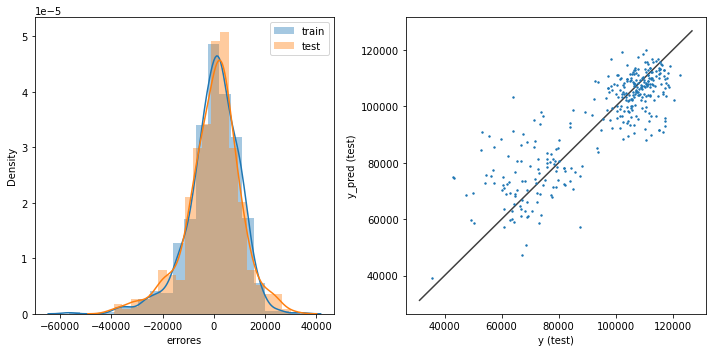

RF_reg
RMSE Train: 2960.0224580083354
RMSE Test: 12484.549237337484
MAE Train: 1971.452519582245
MAE Test: 8996.298419452887
MAPE Train: 0.08993622754022658
MAPE Test: 0.09892798709401995


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


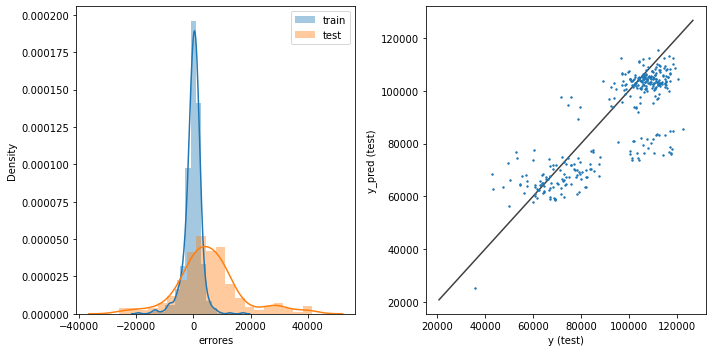

LGBM
RMSE Train: 3521.3694498356567
RMSE Test: 13941.95171735672
MAE Train: 1937.3142187830126
MAE Test: 11420.112753895262
MAPE Train: 0.159624595106308
MAPE Test: 0.1209328144846972


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


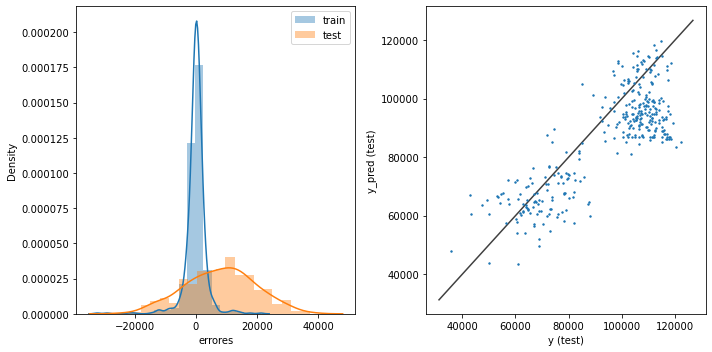

XGB
RMSE Train: 220.84953892996174
RMSE Test: 15121.25846062547
MAE Train: 157.063256286143
MAE Test: 10519.977506411475
MAPE Train: 0.0018763869480799447
MAPE Test: 0.11203455085474372


C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ferna\.conda\envs\datascience\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


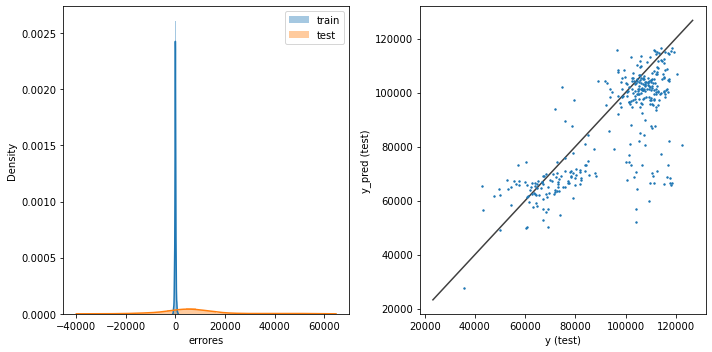

In [394]:
models = [('LinReg', LinReg),('RF_reg', RF_reg), ('LGBM', LGBM),('XGB', XGB)]
for name, model in models:
    print(name)
    val_model(model,X_train,X_test,y_train,y_test)

Podemos notar que incluir las variables tipo de vehículo, forma de pago, sentido, día de la semana en el modelo de predicción no se mejora los resultados anteriormente obtenidos utilizando sólo la serie anterior. Podría estudiarse con más profundidad cuál sería la mejor manera de introducir estas variables en el modelo.

2. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

In [396]:
dataset_inv2=pd.concat([data_2019, data_2018, data_2017])
dataset_inv2.drop(columns=["periodo","hora_inicio"],inplace=True)

# Unificamos nombre forma de pago
dataset_inv2.loc[dataset_inv2["forma_pago"]=="TARJETA DISCAPACIDAD","forma_pago"]="T. DISCAPACIDAD"

# Unificamos nombre estacion Dellepiane
dataset_inv2.loc[(dataset_inv2["estacion"]=="Dellepiane Centro") | (dataset_inv2["estacion"]=="Dellepiane Liniers"),"estacion"]="Dellepiane"

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_inv2['fecha2'] = pd.to_datetime(dataset_inv2.fecha) + pd.to_timedelta(dataset_inv2.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_inv2=dataset_inv2.drop(columns=['fecha','hora_fin'], inplace = False)

#Corregimos el nombre de fecha2 a fecha y cantidad_pasos a "y"
dataset_inv2=dataset_inv2.rename(columns = {'fecha2':'ds',"cantidad_pasos":"y"}, inplace = False) 

#Reordenamos el dataset por fecha
dataset_inv2.sort_values('ds', inplace = True)
dataset_inv2.reset_index(drop=True, inplace = True)

#Asignamos la columna ds como índice
dataset_inv2.set_index("ds")

dia    estacion    sentido tipo_vehiculo  forma_pago  \
ds                                                                              
2017-01-01 00:00:00  Domingo  Dellepiane     Centro       Liviano  NO COBRADO   
2017-01-01 00:00:00  Domingo       Illia  Provincia       Liviano    EFECTIVO   
2017-01-01 00:00:00  Domingo       Illia  Provincia       Liviano  NO COBRADO   
2017-01-01 00:00:00  Domingo  Dellepiane  Provincia       Liviano  INFRACCION   
2017-01-01 00:00:00  Domingo  Avellaneda     Centro       Liviano  NO COBRADO   
...                      ...         ...        ...           ...         ...   
2019-12-31 23:00:00   Martes  Dellepiane  Provincia        Pesado    TELEPASE   
2019-12-31 23:00:00   Martes  Dellepiane  Provincia        Pesado  NO COBRADO   
2019-12-31 23:00:00   Martes  Dellepiane  Provincia        Pesado      EXENTO   
2019-12-31 23:00:00   Martes  Dellepiane  Provincia       Liviano    TELEPASE   
2019-12-31 23:00:00   Martes  Avellaneda     Centro       Liviano      EXENTO   

                       y  
ds                        
2017-01-01 00:00:00    6  
2017-01-01 00:00:00    9  
2017-01-01 00:00:00    3  
2017-01-01 00:00:00    3  
2017-01-01 00:00:00   36  
...                  ...  
2019-12-31 23:00:00   13  
2019-12-31 23:00:00    1  
2019-12-31 23:00:00    2  
2019-12-31 23:00:00  150  
2019-12-31 23:00:00    3  

[3560706 rows x 6 columns]

In [397]:
dataset_inv2.estacion.unique()

array(['Dellepiane', 'Illia', 'Avellaneda', 'Retiro', 'Salguero',
       'Alberdi', 'Sarmiento', 'Alberti', 'PDB'], dtype=object)

In [398]:
dataset_Dellepiane = dataset_inv2.groupby(['estacion']).get_group("Dellepiane").resample('D', on = 'ds').sum()
dataset_Illia = dataset_inv2.groupby(['estacion']).get_group("Illia").resample('D', on = 'ds').sum()
dataset_Avellaneda = dataset_inv2.groupby(['estacion']).get_group("Avellaneda").resample('D', on = 'ds').sum()
dataset_Retiro = dataset_inv2.groupby(['estacion']).get_group("Retiro").resample('D', on = 'ds').sum()
dataset_Salguero = dataset_inv2.groupby(['estacion']).get_group("Salguero").resample('D', on = 'ds').sum()
dataset_Alberdi = dataset_inv2.groupby(['estacion']).get_group("Alberdi").resample('D', on = 'ds').sum()
dataset_Sarmiento = dataset_inv2.groupby(['estacion']).get_group("Sarmiento").resample('D', on = 'ds').sum()
dataset_Alberti = dataset_inv2.groupby(['estacion']).get_group("Alberti").resample('D', on = 'ds').sum()
dataset_PDB = dataset_inv2.groupby(['estacion']).get_group("PDB").resample('D', on = 'ds').sum()

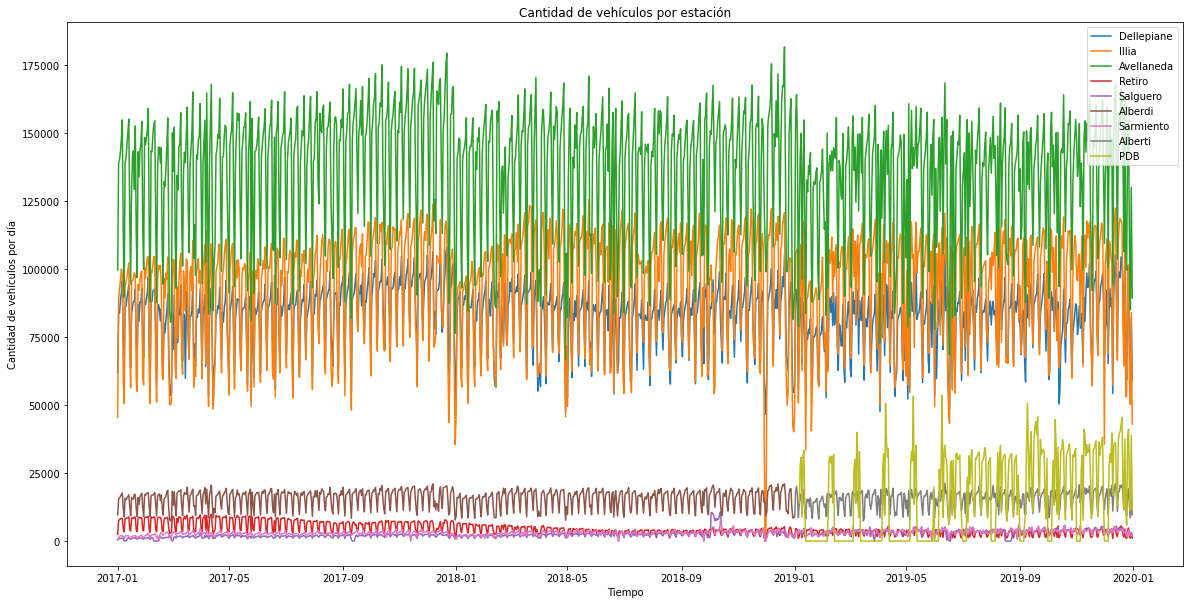

In [399]:
plt.figure(figsize = (20,10))
plt.plot(dataset_Dellepiane.index, dataset_Dellepiane.y, label = "Dellepiane")
plt.plot(dataset_Illia.index, dataset_Illia.y, label = "Illia")
plt.plot(dataset_Avellaneda.index, dataset_Avellaneda.y, label = "Avellaneda")
plt.plot(dataset_Retiro.index, dataset_Retiro.y, label = "Retiro")
plt.plot(dataset_Salguero.index, dataset_Salguero.y, label = "Salguero")
plt.plot(dataset_Alberdi.index, dataset_Alberdi.y, label = "Alberdi")
plt.plot(dataset_Sarmiento.index, dataset_Sarmiento.y, label = "Sarmiento")
plt.plot(dataset_Alberti.index, dataset_Alberti.y, label = "Alberti")
plt.plot(dataset_PDB.index, dataset_PDB.y, label = "PDB")
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.title("Cantidad de vehículos por estación")
plt.show()

Las series de tiempo difieren bastante entre sí, lo que está asociado a la ubicación geográfica de cada una de ellas y la importancia que significan para el fljo vehciular diario de Buenos Aires.

También por ejemplo se ve claramente el momento en que se inauguró la estación de peaje Paseo del Bajo ("PDB") en el año 2019.

3. ¿Hay algo que te gustaría investigar o probar?

Creo que puede tener sentido incorporar la predicción univariada de la serie de tiempo como una variable más de la predicción multivariada para ver si mejora la predicción. Otra idea sería incorporar variables adicionales que hagan referencia a la cantidad de autos que pasaron los últimos 7 días. 
Estas ideas las tendré en cuenta para incorporarlas en el trabajo práctico Nº4